In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision import datasets, models, transforms
import cv2
from PIL import Image
import numpy as np
import pandas as pd
import os

In [2]:
class MyDataset(Dataset):
    """My dataset."""

    def __init__(self, root_dir, class_path, transform=None):
        super(MyDataset, self).__init__()
        self.root_dir = root_dir
        self.class_path = class_path
        self.transform = transform
        
        # get image list
        all_list =  [os.path.splitext(f) for f in os.listdir(self.root_dir)] # jpg + txt
        assert [f for f,e in all_list if e=='.jpg'] == [f for f,e in all_list if e=='.txt'], "num_image != num_txt"
        self.data_list = [f for f,e in all_list if e=='.jpg']
        
        # get class list
        with open(class_path, 'r', encoding='utf-8') as f:
            self.classes = [c for c in f.read().split('\n')]
        self.class_to_idx = {self.classes[i]: i for i in range(len(self.classes))}

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        image_path = os.path.join(self.root_dir, self.data_list[idx]+'.jpg')
        ann_path = os.path.join(self.root_dir, self.data_list[idx]+'.txt')
        img = Image.open(image_path)
        with open(ann_path, 'r') as f:
            anno = [a.split(' ') for a in f.read().strip().split('\n')]
        anno = np.array(anno)
        labels = anno[:,0].astype(np.int)
        bboxes_yolo = anno[:,1:].astype(np.float) # centerX, centerY, w, h [ratio] - yolo style
        bboxes = bboxes_yolo.copy() # x,y,w,h

        if self.transform:
            img = self.transform(img).unsqueeze(0)
            
        bboxes[:,0] = (bboxes_yolo[:,0] - bboxes_yolo[:,2]/2)*img.shape[3] # x
        bboxes[:,1] = (bboxes_yolo[:,1] - bboxes_yolo[:,3]/2)*img.shape[2] # y
        bboxes[:,2] = bboxes_yolo[:,2]*img.shape[3]
        bboxes[:,3] = bboxes_yolo[:,3]*img.shape[2]
        bboxes = bboxes.astype(np.int)

        return img, labels, bboxes

In [3]:
root_dir = 'C:\\Users\\LSW\\Desktop\\Smart_mirror\\Yolo_mark\\x64\\Release\\cosmetic-data\\new-cosmetic-frontview\\temp'
class_path = 'C:\\Users\\LSW\\Desktop\\Smart_mirror\\Yolo_mark\\x64\\Release\\cosmetic-data\\obj.names'

dd_dataset = MyDataset(root_dir, class_path, 
#                       transform=transforms.Compose([
# #         transforms.Resize([224,224]),
# #         transforms.RandomHorizontalFlip(),
# #         transforms.RandomRotation(45),
# #         transforms.ToTensor(),
# #         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ])
)

dd_loader = torch.utils.data.DataLoader(dd_dataset, batch_size=1,
                                          shuffle=False, num_workers=1)


---
# Classification

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, models, transforms
import cv2
from PIL import Image
import numpy as np
import pandas as pd
import os, shutil
from time import sleep
import subprocess
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from torch.distributions.multivariate_normal import MultivariateNormal
from tqdm import tqdm_notebook as tqdm
# import mymodels
# from mymodels.BN_Inception import BN_Inception

def my_cos(x,y):
    _x = F.normalize(x, p=2, dim=1)
    _y = F.normalize(y, p=2, dim=1)
    return _x.matmul(_y.transpose(0,1))

class Flatten(torch.nn.Module):
    """
    torch.nn.Sequential에서 사용가능한 flatten 모듈
    """
    def forward(self, x):
        batch_size = x.shape[0]
        return x.view(batch_size, -1)
    
class OracleModel(nn.Module):
    def __init__(self):
        """Load the pretrained ResNet-152 and replace top fc layer."""
        super(OracleModel, self).__init__()
#         ****torch pretrained net****
#         net = models.shufflenetv2.shufflenet_v2_x1_0(pretrained=True) # 1024
#         net = torch.hub.load('pytorch/vision', 'mobilenet_v2', pretrained=True)
#         net = models.mobilenet_v2(pretrained=True)
#         net = models.densenet201(pretrained=True)
        net = models.resnet50(pretrained=True)

        modules = list(net.children())[:-2]      # resnet conv_5
        self.backbone = torch.nn.Sequential(*modules) # 2048
        avg_pool = torch.nn.AdaptiveAvgPool2d(output_size=(1, 1))
        flatten = Flatten() 
        
#         net = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True, 
#                                                              pretrained_backbone=True)   
#         self.backbone = net.backbone #256 


# #         ****mobilenet****
#         self.BACKBONE_PATH = 'torch_models/mobile_ft.pt'
#         mobilenet = torch.load(self.BACKBONE_PATH)
#         modules = list(mobilenet.children())[:-1]
#         avg_pool = torch.nn.AvgPool2d(7, stride=1)
#         flatten = Flatten()
#         self.backbone = torch.nn.Sequential(*modules, avg_pool, flatten) #1280
        
# #         ****mobilnet distance matric learning****   
#         self.BACKBONE_PATH = 'mymodels/model_000400.pth'
#         self.backbone = torch.load(self.BACKBONE_PATH) #1280    

#         self.backbone = mymodels.create('Resnet50', dim=512, pretrained=True,
#                                         model_path='mymodels/ckp_ep210.pth.tar') #[227,227]->512

#         self.backbone = BN_Inception(dim=512, pretrained=True, 
#                                      model_path='mymodels/bn_inception-52deb4733.pth')

        # fc layer
        self.fc = nn.Sequential(
            avg_pool,
            flatten
        ) # 2048
        
#         self.embed = nn.Sequential(
#             self.backbone,
#             self.fc
#         ) # 2048
    
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.topk = 3
        self.threshold = 0.75
        self.feature_len = 2048

        self.sort_order_descending = False
        self.cos = nn.CosineSimilarity(dim=1, eps=1e-6)
        self.roi_upsample = nn.UpsamplingBilinear2d([224,224])
        self.roi_transform = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                    ])
        
    def embed(self, images):
        r = self(images)
        return self.fc(r)

    def forward(self, images):
        """Extract feature vectors from input images."""
        return self.backbone(images)
#         return self.backbone(images)[3]    
    

    def makeAllReference_online(self, referenceImgDirPath):
        """
        임베딩 디비 생성... flask 서버용 
        utils.makeAllReferenceCSV 에서 csv 저장만 안함
        """
        reference_dataset = torchvision.datasets.ImageFolder(
            root=referenceImgDirPath,
            transform=transforms.Compose([
#                 transforms.Resize([224,224]),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        )
        reference_loader = torch.utils.data.DataLoader(
            reference_dataset,
            batch_size=32,
            num_workers=0,
            shuffle=False
        )
        
        # get all data and input to model
        _temp = []
        for data, target in tqdm(reference_loader):
            outputs = self.embed(data.to(self.device)).data # .data 안하면 메모리 오버플로남...
            _temp.append(outputs)

        represented = torch.cat(_temp, dim=0)
        # raw data label 별 평균 구해두기
        self.df_ref_online = pd.DataFrame(represented.cpu().numpy())
        self.df_ref_online['label'] = [reference_dataset.classes[i] for i in reference_dataset.targets]
        self.reference_means_online = self.df_ref_online.groupby('label').mean()
        self.dir_list_online = reference_dataset.classes

        # 즉각 임베딩 디비 생성
        self.setReferenceDataset(self.dir_list_online, self.df_ref_online, self.reference_means_online)
        return self.dir_list_online, self.df_ref_online, self.reference_means_online

    def addNewData_online(self, im_arr, label):
        """
        @params im_arr: h X w X 3 (RGB)
        @params label: "praL"
        """
        data = self.roi_transform(im_arr).unsqueeze(0)
        outputs = self.embed(data.to(self.device)).data
        new_feature = list(outputs.squeeze().cpu().numpy())
        new_feature.append(label)
        new_feature[-1]
        # concat to prev df_ref_online
        self.df_ref_online.loc[self.df_ref_online.shape[0]] = new_feature
        # revise reference_means_online 
        self.reference_means_online = self.df_ref_online.groupby('label').mean()
        # 즉각 임베딩 디비 생성
        self.setReferenceDataset(self.dir_list_online, self.df_ref_online, self.reference_means_online)
        print('[Detector]: addNewData_online -', label)
        return

    def addNewLabel_online(self, dirPath, label):   
        """
        @params dirPath: "server/vu-visor/static/images_ext"
        @params label: "praL"
        """
        finalDirPath = os.path.join(dirPath, label)
        ims = [Image.open(os.path.join(finalDirPath,i)) for i in os.listdir(finalDirPath)] # n_img X h X w X c
        ims_tensor = torch.stack([self.roi_transform(im) for im in ims])
        outputs = self.embed(ims_tensor.to(self.device)).data
        new_features =outputs.cpu().numpy() # n_img X 2048

        new_df_ref_online = pd.DataFrame(new_features)
        new_df_ref_online['label'] = label
        # add new label
        if label not in self.dir_list_online: # 중복된 이름 없을 시 새로 등록
            self.dir_list_online.append(label)
            self.dir_list_online.sort() # 반드시 소팅해서 클래스 번호 재정렬 해줘야함
        # concat to prev df_ref_online
        _df_ref_online_non_overlap = self.df_ref_online[self.df_ref_online['label']!=label] # 중복된 이전 데이터 제거
        self.df_ref_online = pd.concat([_df_ref_online_non_overlap, new_df_ref_online], ignore_index=True)
        # revise reference_means_online 
        self.reference_means_online = self.df_ref_online.groupby('label').mean()
        # 즉각 임베딩 디비 생성
        self.setReferenceDataset(self.dir_list_online, self.df_ref_online, self.reference_means_online)
        print('[Detector]: addNewLabel_online -', label)
        return 
        
    # 임베딩 디비 생성
    def setReferenceDataset(self, sample_dir_list, df_ref_feature_sampled, reference_means_sampled):
        self.reference_classes = sample_dir_list
        self.reference_targets = list(df_ref_feature_sampled.iloc[:,-1])
        self.embedded_features_cpu = torch.tensor(df_ref_feature_sampled.iloc[:,:-1].as_matrix()).float().data # float64->float32(torch default), cpu
        self.embedded_features = self.embedded_features_cpu.to(self.device) # gpu
        self.embedded_means_numpy = reference_means_sampled.as_matrix()
        self.embedded_means = torch.tensor(self.embedded_means_numpy).float().data.to(self.device) # float64->float32(torch default), gpu

        self.c2i = {c:i for i,c in enumerate(self.reference_classes)}
        self.embedded_labels = torch.tensor([self.c2i[c] for c in self.reference_targets]).to(self.device)
        
        # make datafames for plot
        # ***필요없음 어차피 pca 해야함
        self.df_ = pd.DataFrame(np.array(self.embedded_features_cpu))
        self.df_['name'] = self.reference_targets
        self.centers_ = pd.DataFrame(self.embedded_means_numpy)
        self.centers_['name'] = self.reference_classes

    def fit_pca(self, n_components=4):
        # pca model fit
        self.n_components = n_components
        self.pca = PCA(n_components=self.n_components) # 2048 차원 다쓰면 나중에 샘플링에서 계산 오류남, sample 개수보다 많으면 촐레스키 분해 에러나는듯
        self.transformed = self.pca.fit_transform(self.embedded_features_cpu)

        # show PCA features 
        self.df = pd.DataFrame(self.transformed)
        self.df['name'] = self.reference_targets
        self.centers = pd.DataFrame(self.pca.transform(self.embedded_means_numpy))
        self.centers['name'] = self.reference_classes

    def inference_tensor3(self, inputs, metric='cos', knn=True):
        """
        roi 피처맵을(nxcx7x7) 인풋으로 받음
        @params metric: [l2, mahalanobis, prob]
        @params inputs: # N x C x H x W
        """            
        # inputs shape: Batch*C*H*W
        # input to backbone model
        self.inputs = inputs
        self.outputs = self.fc(self.inputs).data # n_roi X features 2048    

        # inference
        self.sort_order_descending = True         
        if knn: self.dists = my_cos(self.outputs, self.embedded_features)
        else: self.dists = my_cos(self.outputs, self.embedded_means)

        self.dists_sorted = self.dists.sort(dim=1, descending=self.sort_order_descending)
        if knn: self.predicts = self.embedded_labels[self.dists_sorted.indices][:,:self.topk]
        else: self.predicts = self.dists_sorted.indices[:,:self.topk]

        self.predicts_dist = self.dists_sorted.values[:,:self.topk]
        return self.predicts.data, self.predicts_dist.data    
    
    def inference_tensor_texture(self, inputs, metric='cos', knn=True, SUM=True):
        """
        현재 미니배치 1인 경우만 작동
        roi 피처맵을(nxcx7x7) 인풋으로 받음
        @params metric: [l2, mahalanobis, prob]
        @params inputs: # N x C x H x W
        """            
        # inputs shape: Batch*C*H*W
        # input to backbone model
        # 1 X 2048 X 7 X 7 --> 7*7 X 2048 --> 1 X 3
        # n X 2048 X 7 X 7 --> n*7*7 X 2048 --> n X 3
        self.outputs = inputs.data.transpose(1,2).transpose(2,3).reshape(-1,inputs.shape[1])
        # self.outputs = inputs.squeeze().transpose(0,1).transpose(1,2).reshape(-1,inputs.shape[1]).data 
        # 7*7 X features 2048   
        
        # inference
        self.sort_order_descending = True         
        if knn: self.dists = my_cos(self.outputs, self.embedded_features)
        else: self.dists = my_cos(self.outputs, self.embedded_means)

        self.dists_sorted = self.dists.sort(dim=1, descending=self.sort_order_descending)
        if knn: self.predicts = self.embedded_labels[self.dists_sorted.indices][:,:self.topk]
        else: self.predicts = self.dists_sorted.indices[:,:self.topk]

        self.predicts_dist = self.dists_sorted.values[:,:self.topk]

        if(SUM):
    #             ---- dist sum mode ----
            aa = pd.DataFrame(list(zip(self.predicts[:,0].cpu().numpy(), self.predicts_dist[:,0].cpu().numpy())), columns=['label','dist'])
            self.aa = aa
            # pp = aa.groupby('label').sum()
            # pp = pp.sort_values(by='dist', ascending=False)
            # pp = list(pp.index[:3])
            # if(len(pp)!=self.topk):
            #     pp = pp*self.topk
            #     pp = pp[:self.topk]
            
            # 배치별 번호 매기기
            self.aa['batch'] =  np.repeat(np.arange(inputs.shape[0]), inputs.shape[2]*inputs.shape[3])
            # 다중 그루핑
            zz = self.aa.groupby(['batch', 'label']).agg(['sum', 'mean', 'max'])
            # 2중 컬럼 인덱스 해제
            zz.columns = zz.columns.droplevel(0) 
            # sum 순으로 정렬
            zz = zz.reset_index().sort_values(by=['batch', 'sum'], ascending=False).set_index(['batch', 'label'])
            # 배치별 가장 큰 값만 리턴, dist는 선택 레이블의 평균값
            preds = zz.groupby('batch').head(1).sort_index(0).index.get_level_values(level=1).tolist()
            preds = np.repeat(preds, 3).reshape(-1,3)
            return torch.tensor(preds).data
        else:
    #             ---- voting mode ----
            c = Counter(torch.cat([*self.predicts]).cpu().numpy())
            self.c = c
            pp = list(zip(*(c.most_common()[:3])))[0]
            if(len(pp)!=self.topk):
                pp = pp*self.topk
                pp = pp[:self.topk]    
            return torch.tensor([pp]).data        

    def inference_tensor4(self, inputs):
        """
        roi 피처맵을(nxcx7x7) 인풋으로 받음
        """            
        # inputs shape: Batch*C*H*W
        # input to backbone model
        self.inputs = inputs
        self.outputs = self.fc(self.inputs).data # n_roi X features 2048    

        # inference
        self.dists = my_cos(self.outputs, self.embedded_means)
        self.predicts_dist = self.dists
        return self.predicts_dist.data    

    # 각 레이블 별 평균과의 L2 거리 계산 (PCA 적용안함)
    def calc_l2(self, label):
        mu = self.embedded_means[label]
        xx = self.outputs

        # 20*1280 X 1280*20 --diag--> 20
        # num_roi*dim X dim*num_roi --diag--> num_roi
        xx_sub_mu = xx.sub(mu)
        l2_dist = xx_sub_mu.matmul(xx_sub_mu.t()).sqrt().diag()
        return l2_dist.cpu()

    # 각 레이블 별 평균과의 cosine simility 계산 (PCA 적용안함)
    def calc_cos(self, label):
        mu = self.embedded_means[label]
        xx = self.outputs

        # 20*1280 X 1280*20 --diag--> 20
        # num_roi*dim X dim*num_roi --diag--> num_roi
        mu = mu.unsqueeze(0)
        cos_dist = self.cos(xx, mu)
        return cos_dist.cpu()        

    def inference_file(self, imgPath):              
        # imgPath = "./server/oracle_proj/predict.jpg"
        frame = cv2.imread(os.path.join(imgPath), cv2.IMREAD_COLOR)
        return self.inference_tensor(frame)

    def show_img(self, imgPath):
        frame = cv2.imread(os.path.join(imgPath), cv2.IMREAD_COLOR)
        # opencv frme input // H*W*C(BGR)
        # 0-255 3 channel
        inputs = torch.Tensor(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))/255 # 여기 Tensor 소문자로 바꾸면 안됨... 차이 알아보기
        plt.imshow(inputs)
        plt.show()
        
    def show_tensor(self, t):
        plt.imshow(t.numpy().transpose([1,2,0]))
        plt.show()
        
    def plot(self):
        self.fit_pca(n_components=4)
        _outputs = self.pca.transform(self.outputs.cpu())

        plt.figure(figsize=(18,9))
        plt.title("Vector space, pca_n: "+str(self.feature_len))
        ax = sns.scatterplot(x=0, y=1, hue='name', data=self.df, palette="Set1", legend="full")
        ax2 = sns.scatterplot(x=0, y=1, hue='name', data=self.centers, palette="Set1", s=150, legend=None, edgecolor='black')
        plt.scatter(_outputs[:,0], _outputs[:,1], marker='x', c='black')
        plt.show()

    # save plot image for web
    def save_plot(self, plotPath):
        self.fit_pca(n_components=4)
        _outputs = self.pca.transform(self.outputs.cpu())

        plt.figure(figsize=(9,9))
        plt.title("Vector space, pca_n: "+str(self.feature_len))
        ax = sns.scatterplot(x=0, y=1, hue='name', data=self.df, palette="Set1", legend="full", s=30)
        ax2 = sns.scatterplot(x=0, y=1, hue='name', data=self.centers, palette="Set1", s=150, legend=None, edgecolor='black')
        plt.scatter(_outputs[:,0], _outputs[:,1], marker='x', c='black', s=120)
        plt.savefig(plotPath)

In [4]:
model = OracleModel()
model.to(model.device)
model.eval()

OracleModel(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d

In [5]:
"""
차후 util로 리팩토링
"""
import PIL
from collections import Counter 

import torchvision.transforms.functional as TF
import random

# def my_segmentation_transforms(image, segmentation):
#     if random.random() > 0.5:
#         angle = random.randint(-30, 30)
#         image = TF.rotate(image, angle)
#         segmentation = TF.rotate(segmentation, angle)
#     # more transforms ...
#     return image, segmentation

# class MyRotationTransform:
#     """Rotate by one of the given angles."""

#     def __init__(self, angles):
#         self.angles = angles

#     def __call__(self, x):
#         angle = random.choice(self.angles)
#         return TF.rotate(x, angle)

# rotation_transform = MyRotationTransform(angles=[-30, -15, 0, 15, 30])


def myRotation(image):
    return TF.rotate(image, 90, expand=True)

def myTencCrop(image):
    return TF.ten_crop(image, 224, vertical_flip=False)

# -------------- 전체 임베딩 피처 디비 생성 --------------
def makeAllReferenceCSV(referenceImgDirPath, featuresPath, meanPath, n_sample):
    """
    전체 임베딩 피처 dataframe 생성 후 csv로 저장
    """
    reference_dataset = torchvision.datasets.ImageFolder(
        root=referenceImgDirPath,
        transform=transforms.Compose([
#             transforms.RandomRotation(90, expand=True),
            transforms.Resize([224,224]),
#             myRotation,
#             transforms.RandomHorizontalFlip(),
#             transforms.RandomRotation(45),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    )
    reference_loader = torch.utils.data.DataLoader(
        reference_dataset,
        batch_size=32,
        num_workers=0,
        shuffle=False
    )

    # get all data and input to model
    _temp = []
    for data, target in tqdm(reference_loader):
        outputs = model.embed(data.to(model.device)).data # .data 안하면 메모리 오버플로남...
        _temp.append(outputs)       

    represented = torch.cat(_temp, dim=0)
    # raw data label 별 평균 구해두기
    df_ref = pd.DataFrame(represented.cpu().numpy())
    df_ref['label'] = [reference_dataset.classes[i] for i in reference_dataset.targets*1]
    
    # sampling
    df_ref_sampled = df_ref.groupby('label').apply(pd.DataFrame.sample, n=n_sample).reset_index(drop=True)
    reference_means = df_ref_sampled.groupby('label').mean()

    # 자료 저장
    df_ref_sampled.to_csv(featuresPath, encoding='utf8', index=False)
    reference_means.to_csv(meanPath, encoding='utf8', index=True)
    return


def set_sample_val_img(imgValPath, imgValTempPath, n_class_for_val, musthave_list=[]):
    """
    n개 클래스만 validation 샘플링 하는 함수
    @param imgValPath = '.\\img_real\\val'
    @param imgValTempPath = '.\\img_real\\_val_temp'
    @param n_class_for_val = 20
    @musthave_list = 반드시 포함할 리스트
    """
    all_dir_list = os.listdir(imgValPath)
    sample_dir_list = np.random.permutation(all_dir_list)[:n_class_for_val]
    for i in musthave_list:
        if i not in sample_dir_list: sample_dir_list = np.concatenate([sample_dir_list, [i]])

    # 추출될 이미지 저장 폴더 비우기... 비동기 버그 때문에 sleep넣음 
    if os.path.isdir(imgValTempPath): shutil.rmtree(imgValTempPath)
    sleep(0.1)
    os.makedirs(imgValTempPath)

    # copy sampled dir
    for class_name in tqdm(sample_dir_list):
        if not os.path.isdir(os.path.join(imgValTempPath, class_name)):
            os.mkdir(os.path.join(imgValTempPath, class_name))
        command = ['cmd', '\/c', 'copy',  os.path.join(imgValPath, class_name) , os.path.join(imgValTempPath, class_name)]    
        subprocess.check_output(command)
    sample_dir_list.sort() # 토치 데이터로더도 자동으로 이름순 소팅하므로 꼭 해야함
    return list(sample_dir_list)

def get_sample_reference(featuresPath, meanPath, showData=False):
    """
    n개 클래스 임베딩 & 레이블 & means 추출 
    """
    # load saved embedding features & means
    df_ref = pd.read_csv(featuresPath, encoding='utf8')
    reference_means = pd.read_csv(meanPath, encoding='utf8', index_col='label')
    
    if showData:
        display(df_ref)
        display(reference_means)

    df_ref_featere_sampled = None
    for c in sample_dir_list:
        _df = df_ref[df_ref['label'] == c]
        if df_ref_featere_sampled is None: df_ref_featere_sampled = _df
        else: df_ref_featere_sampled = df_ref_featere_sampled.append(_df)

    df_ref_featere_sampled = df_ref_featere_sampled.reset_index(drop=True)
    reference_means_sampled = reference_means.loc[sample_dir_list]
    return df_ref_featere_sampled, reference_means_sampled

def calcWindowSlidePreds(target_all, preds_all, n_window=7, mode="first"):
    """
    target_all = 정답 리스트
    preds_all = 예측값 리스트 
    mode = 'all' # first, all
    n_window = 3 
    @return new_preds_all = []
    """
    
    # preds, gt 모아서 데이터프레임화
    df = pd.DataFrame(preds_all.numpy())
    df['gt']= target_all.numpy()

    # 클래스별 인덱스 시작점 계산. 데이터로더 셔플하면 안됨
    df_agg = df.groupby('gt').count()
    df_agg['end_idx'] = df_agg[0].cumsum()

    # 윈도 내 데이터 voting
    startidx = 0
    new_preds_all = []
    for i in df_agg.index:
        for idx in range(startidx, df_agg['end_idx'][i]):
            bookmarkidx = idx-n_window+1 if idx-n_window>=0 else 0
            if idx-n_window<startidx:
                bookmarkidx = startidx

            if mode=='all': # 1~3위 까지 전체 사용 모드, [::-1] 은 가장 최근 값을 맨 앞으로 보내려고
                res = np.concatenate(preds_all[bookmarkidx:idx+1].numpy()[::-1])
            elif mode=='first': # 1위만 사용모드       
                res = preds_all[bookmarkidx:idx+1, 0].numpy()[::-1]
            res_cnt = Counter(res) # counter는 먼저나온 값이 먼저 등록됨, 즉 카운터가 동률이면 최신값이 가장 먼저 나옴
#             print(idx-n_window, idx, bookmarkidx, idx+1, res, res_cnt.most_common()[:2], '[Pred]:', res_cnt.most_common()[0][0])
            new_preds_all.append(res_cnt.most_common()[0][0])
#         print('-------------------------')
        startidx = df_agg['end_idx'][i]
    return new_preds_all

In [6]:
"""
전체 피처 데이터 재생성
"""
# referenceImgDirPath = '.\\new-cosmetic-frontview\\images_bbox'
referenceImgDirPath = '.\\references\\images_trimed'
# referenceImgDirPath = 'C:\\Users\\LSW\\Downloads\\mask_img\\images_trimed_10shot_class' # 쿠다 메모리부족 이거 잔반사이즈로 줄여보자
# referenceImgDirPath = 'C:\\Users\\LSW\\Desktop\\Smart_mirror\\Yolo_mark\\x64\\Release\\cosmetic-data\\new-cosmetic-frontview'

featuresPath = 'cosmetic_features_cos.csv'
meanPath = 'cosmetic_means_cos.csv'
makeAllReferenceCSV(referenceImgDirPath, featuresPath, meanPath, n_sample=10)

A Jupyter Widget

In [7]:
%%time
print('**********data folder re-generating***********')
# imgValPath = 'C:\\Users\\LSW\\Downloads\\mask_img\\images_trimed_class'
imgValPath = 'new-cosmetic-wall\\images_full'
imgValTempPath = imgValPath
n_class_for_val = 100
musthave_list = []

# -------------- n개 클래스만 validation 샘플링 세팅 및 폴더정리 ----------------
reference_dataset = torchvision.datasets.ImageFolder(
    root=imgValPath,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
)
sample_dir_list = reference_dataset.classes

# -------------- 레퍼런스 데이터에서 n개 클래스 임베딩 & 레이블 & means 추출 -----------------
featuresPath = 'cosmetic_features_cos.csv'
meanPath = 'cosmetic_means_cos.csv'

df_ref_featere_sampled, reference_means_sampled = get_sample_reference(featuresPath, meanPath, showData=True)

# ---------------------------- 레퍼런스셋 로드 및 임베딩 세팅 ---------------------------------
model.setReferenceDataset(sample_dir_list, df_ref_featere_sampled, reference_means_sampled)

**********data folder re-generating***********


,0,1,2,3,4,5,6,7,8,9,...,2039,2040,2041,2042,2043,2044,2045,2046,2047,label
0,1.962230,0.634215,1.762289,0.346774,0.795343,1.603183,0.481070,0.905347,0.674828,0.349498,...,0.120148,0.248649,1.014116,0.856644,0.047016,0.540215,0.319471,0.029558,0.648788,AHC-AGELESS REAL EYE CREAM FOR FACE
1,0.292931,0.171503,0.336534,0.247473,0.377912,0.426336,0.610317,0.269301,0.345637,0.618459,...,0.253188,0.326929,0.922763,0.499330,0.136215,0.200068,0.335404,0.873404,0.543847,AHC-AGELESS REAL EYE CREAM FOR FACE
2,0.763730,0.743478,0.576283,0.349067,0.882857,0.676584,0.687578,0.295555,0.450270,0.221745,...,0.060055,0.719661,0.252421,0.391949,0.198340,0.188123,0.076950,1.032727,0.530091,AHC-AGELESS REAL EYE CREAM FOR FACE
3,0.301848,0.447783,0.737731,0.204914,0.392145,0.920094,0.310044,0.199206,0.146459,0.050588,...,0.263989,0.420457,0.580487,0.095794,0.057374,0.594879,0.874467,0.512844,0.985858,AHC-AGELESS REAL EYE CREAM FOR FACE
4,0.244127,0.184330,0.819666,0.345009,1.507725,0.733602,0.078871,0.051953,0.121963,0.028002,...,0.387964,0.366459,0.357513,0.493359,0.087185,0.276187,0.137212,0.291368,0.482486,AHC-AGELESS REAL EYE CREAM FOR FACE
5,0.286908,0.638167,0.504821,0.953634,1.229272,0.395511,0.609032,0.480495,0.496181,0.144793,...,0.220969,0.466954,0.528801,0.524667,0.054932,0.315039,0.066368,0.591765,0.788102,AHC-AGELESS REAL EYE CREAM FOR FACE
6,0.578087,0.248218,0.514632,0.163960,0.849013,0.765053,0.170342,0.142443,0.560472,0.114268,...,0.135399,0.553502,0.225535,0.221884,0.153978,0.560552,0.257352,0.179032,0.527746,AHC-AGELESS REAL EYE CREAM FOR FACE
7,0.291725,0.810916,0.421925,0.247961,1.144184,0.468369,0.986288,0.165894,0.357976,0.081195,...,0.140765,0.526131,0.576257,0.310619,0.017076,0.498467,0.186277,0.279670,1.076008,AHC-AGELESS REAL EYE CREAM FOR FACE
8,0.245856,1.309269,0.354200,0.468166,0.620318,1.559992,0.909708,0.196827,0.343104,0.067652,...,0.208137,0.476136,0.327448,0.628182,0.062936,0.471073,0.147845,0.257986,0.483393,AHC-AGELESS REAL EYE CREAM FOR FACE
9,0.991540,1.020746,1.798223,0.401704,0.856955,1.127063,1.046117,0.556211,0.517635,0.320038,...,0.315602,0.634980,0.327900,0.244039,0.220743,0.336442,0.044026,0.385989,0.324572,AHC-AGELESS REAL EYE CREAM FOR FACE


,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
label,,,,,,,,,,,,,,,,,,,,,
AHC-AGELESS REAL EYE CREAM FOR FACE,0.595898,0.620862,0.782630,0.372866,0.865572,0.867579,0.588937,0.326323,0.401452,0.199624,...,0.357309,0.210621,0.473986,0.511324,0.426647,0.103579,0.398105,0.244537,0.443434,0.639089
AHC-Aura Secret Toneup Cream,1.054011,0.622681,0.648932,0.275406,0.845097,1.325203,0.211126,0.610700,0.607209,0.364169,...,0.504371,0.333760,0.260148,0.496564,0.344852,0.137710,0.362940,0.175171,0.171751,0.447329
AHC-ONLY FOR MAN LOTION,0.880064,0.642577,0.375419,0.279884,0.667784,1.294147,0.337347,0.363517,0.314671,0.110135,...,0.364519,0.157482,0.258695,0.373834,0.698629,0.117164,0.385960,0.191635,0.432352,0.878485
APIEU-데카소사이드 시카 겔 데이크림,0.770810,0.429338,0.970785,0.296757,0.605249,0.271531,1.165556,0.360761,0.136821,0.225628,...,0.376655,0.154890,0.451345,0.842029,0.324957,0.076004,0.725883,0.321302,0.739618,1.538574
APIEU-스타트업 포어 프라이머,0.595281,0.539849,1.135122,0.379003,0.867806,0.855222,1.165075,0.615393,0.840824,0.426609,...,0.338485,0.161453,0.499560,0.564651,0.559215,0.103378,0.219622,0.279469,0.259563,0.693388
BANILACO-프라임 프라이머 클래식,0.968930,0.981175,0.986927,0.246411,0.794232,0.914248,0.799592,0.450996,0.490647,0.195330,...,0.217088,0.275959,0.506470,0.470177,0.675262,0.042073,0.276916,0.368345,0.780443,1.224497
BELIF-The true cream AQUA BOMB,0.805498,0.794122,0.763466,0.155446,0.592697,0.647344,0.939137,0.712499,0.426424,0.265957,...,0.472759,0.118628,0.319680,0.675268,0.565860,0.108049,0.475629,0.446437,0.684943,1.300176
CLIO-스파클링 라인 프리즘 에어 아이섀도우,0.657270,0.453874,0.403990,0.148047,0.943197,0.157203,0.684201,0.484144,0.586222,0.201247,...,0.296318,0.186136,0.344578,0.637026,0.525074,0.068620,0.207190,0.112811,0.222161,0.539717
FERRAGAMO-INCANTO CHARMS,1.487963,0.727678,0.984692,0.412315,0.490325,0.244545,0.175810,0.430450,0.554753,0.241442,...,1.044532,0.271818,0.305372,1.012204,0.453314,0.124968,0.365864,0.223584,0.706462,0.423320


Wall time: 399 ms


In [142]:
%%time
# ---------------------------- validation set 로드 ---------------------------------
val_dataset = torchvision.datasets.ImageFolder(
    root=imgValTempPath,
    transform=transforms.Compose([
        transforms.Resize([224,224]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=32,
    num_workers=4,
    shuffle=False
)

assert val_dataset.classes==sample_dir_list, "샘플링 클래스와 데이터로더 클래스가 다름"
# ---------------------------- validation set 정확도 측정 ---------------------------------
print('**********calculating***********')

target_all = []
preds_all = []
for data, target in tqdm(val_loader):
    data = data.to(model.device)
    preds, preds_dist = model.inference_tensor3(model(data).data, 'cos', knn=True)
    target_all.append(target)
    preds_all.append(preds)
    

target_all=torch.cat(target_all, dim=0)
preds_all=torch.cat(preds_all, dim=0).data.cpu()
top1_acc = target_all.eq(preds_all[:,0]).float().mean()
top3_acc = np.mean([t in p for t,p in zip(target_all, preds_all)])

# window slide 보정
new_preds_all = calcWindowSlidePreds(target_all, preds_all, n_window=7, mode="all")
new_top1_acc = target_all.eq(torch.tensor(new_preds_all)).float().mean()

# groupby 통계량 보기
_res = []
for t,p in zip(target_all.numpy(), preds_all.numpy()):
    _res.append([val_dataset.classes[t],t,p,t==p[0], t in p])
_df_res = pd.DataFrame(_res, columns=['label', 'target', 'pred', 'top1', 'top3'])
res_agg_df = _df_res.groupby('label').mean()
res_agg_df['count'] = list(_df_res.groupby('target').count()['label'])

display(res_agg_df)
print("[window top-1 acc]:", new_top1_acc)
print("[top-1 acc]:", top1_acc, " [top-3 acc]:", top3_acc, " [all count]:",len(target_all))

**********calculating***********


A Jupyter Widget

KeyboardInterrupt: 

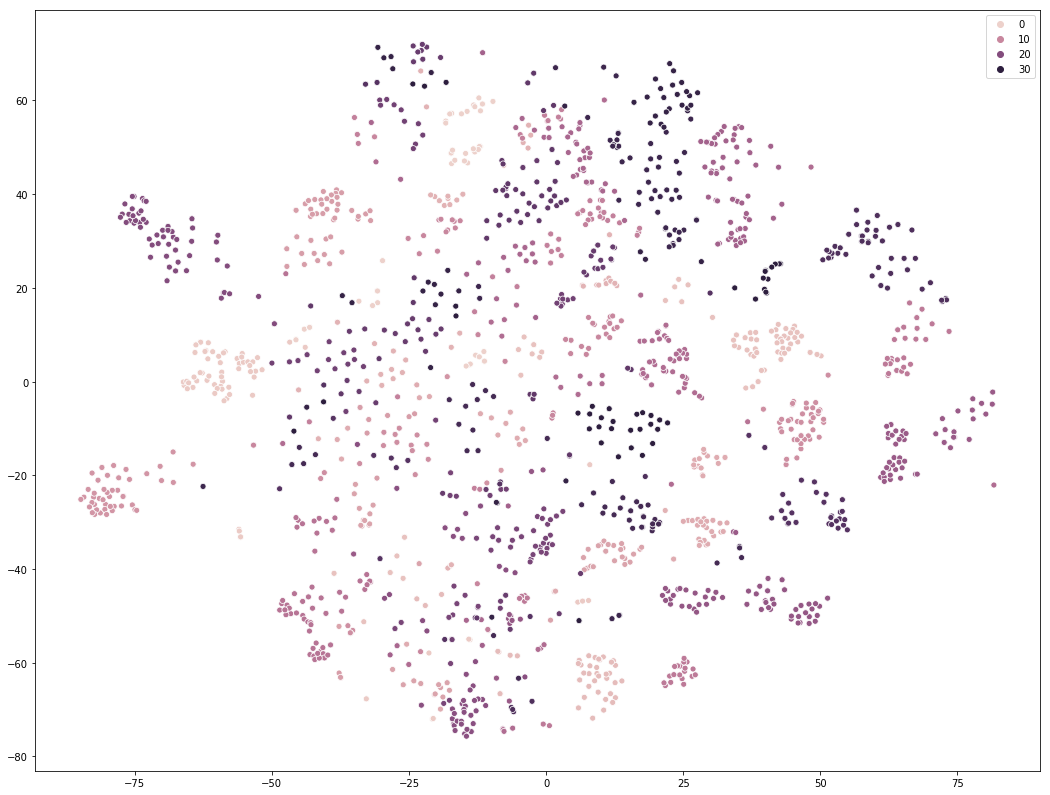

In [26]:
# import matplotlib.pyplot as plt
# from sklearn.manifold import TSNE
# import seaborn as sns

# _model = TSNE()
# feature = df_ref_featere_sampled.iloc[:,:-1]
# %time transformed = _model.fit_transform(feature)

# xs = transformed[:,0]
# ys = transformed[:,1]
plt.figure(figsize=(18,14))
sns.scatterplot(x=xs, y=ys,
                     hue=pd.factorize(df_ref_featere_sampled['label'])[0])
plt.show()

---
# Detecter Performance

In [8]:
# ------------- non max suppression -------------
# https://wns349.github.io/2018/10/16/nms/
from itertools import combinations, permutations

# Calc IOU
def calcIOU(box1, box2):
    """
    box - x,y,w,h
    """
    area_box1 = box1[2]*box1[3]
    area_box2 = box2[2]*box2[3]
    x1_max = max(box1[0], box2[0])
    x2_min = min(box1[0]+box1[2], box2[0]+box2[2])
    y1_max = max(box1[1], box2[1])
    y2_min = min(box1[1]+box1[3], box2[1]+box2[3])
    
    area_intersection = max(0, x2_min-x1_max) * max(0, y2_min-y1_max)
    area_union = area_box1+area_box2-area_intersection +1e-9
    return area_intersection/area_union

def non_max_sup_one_class(bboxes, threshold=0.2, descending=False):
    """
    @params threshold - 
    @params ascending - 기본이 내림차순,
    """
    bboxes = list(bboxes)
    bboxes.sort(key = lambda x: x[2], reverse=descending) # 거리값이므로 오름차순, 확률이면 내림차순  
    bboxes = np.array(bboxes)
    keeps = [True]*len(bboxes)

    for i, bbox in enumerate(bboxes):
        if not keeps[i]: continue
        for j in range(i+1, len(bboxes)):
            if not keeps[i]: continue
            iou_res = calcIOU(bbox[0], bboxes[j][0])
            if iou_res>threshold: keeps[j] = False
    return bboxes[keeps]

def rpn3(box, n_slice_x, n_slice_y):
    """
    n분할 rpn 조합
    @params box: x,y,w,h
    @params im: nomalized image tensor N x C x W x H
    @return 
    """
    w = box[2]/n_slice_x
    h = box[3]/n_slice_y
    
    rois = []
    boxes = []
    
    coords = np.array(np.meshgrid(list(range(n_slice_x+1)), list(range(n_slice_y+1)))).T.reshape(-1,2)
    
    for a,b in combinations(coords,2):
        if a[0]>=b[0] or a[1]>= b[1]: continue # 넓이 없는 사각형 제거
#         print(a,b)
        boxes.append([box[0]+a[0]*w, box[1]+a[1]*h, 
                      (b[0]-a[0])*w, (b[1]-a[1])*h]) # x,y,w,h

    boxes = torch.tensor(boxes)
    return boxes

def get_rois(images, featuremaps, bboxes, texture_mode=False, n_slice=3):
    """
    roi-align from feature map
    @params images - 원본 이미지 (사이즈 계산용)
    @params featuremaps - CNN Backbone 거쳐 나온 것
    @params bboxes - 원본 이미지에서의 bboxes (x,y,w,h)
    @return 피처맵에서 스케일된 bbox부분 7x7로 roi-align된 피처맵
    """
    # calc bbox ratio
    ratio_y = featuremaps.shape[2]/images.shape[2]
    ratio_x = featuremaps.shape[3]/images.shape[3]
    bboxes_scaled = bboxes.clone()#.detach()

    bboxes_scaled[:,0] = bboxes_scaled[:,0]*ratio_x # for x
    bboxes_scaled[:,1] = bboxes_scaled[:,1]*ratio_y # for y
    bboxes_scaled[:,2] = bboxes_scaled[:,2]*ratio_x # for w
    bboxes_scaled[:,3] = bboxes_scaled[:,3]*ratio_y # for h

    # x,y,w,h -> x1, y1, x2, y2 그래디언트 학습되는 변수가 아니므로 inplace 계산 들어가도 괜찮다
    bboxes_scaled[:, 2] = bboxes_scaled[:, 0] + bboxes_scaled[:, 2]
    bboxes_scaled[:, 3] = bboxes_scaled[:, 1] + bboxes_scaled[:, 3]
    
    crops = torchvision.ops.roi_align(featuremaps, [bboxes_scaled], [7,7])
    return crops

In [9]:
# -------------------- edgebox RPN ----------------------------
# https://github.com/opencv/opencv_contrib/blob/master/modules/ximgproc/samples/edgeboxes_demo.py
# https://donghwa-kim.github.io/EdgeBoxes.html - 엣지박스 간단 설명

edge_model = ".\\server\\vu-visor\\model.yml.gz"
edge_detection = cv2.ximgproc.createStructuredEdgeDetection(edge_model)

def rpn(im_opencv, num_boxs, scale=1, min_score=0.01):
    """
    region proposal network
    """
    global edge_detection
    
    def makeEdgeBox(scale):
        im_opencv_scaled = cv2.resize(im_opencv, (int(im_opencv.shape[1]*scale), int(im_opencv.shape[0]*scale)), 
                                      interpolation=cv2.INTER_CUBIC).astype(np.float32)

        edges = edge_detection.detectEdges(im_opencv_scaled / 255.0)
        orimap = edge_detection.computeOrientation(edges)
        edges = edge_detection.edgesNms(edges, orimap)
        
        edge_boxes = cv2.ximgproc.createEdgeBoxes() 
        edge_boxes.setBeta(0.75) # beta=0.1, nms threshold for object proposals.
        edge_boxes.setMaxBoxes(num_boxs)
        edge_boxes.setMinScore(min_score) # box score
        boxes, scores = edge_boxes.getBoundingBoxes(edges, orimap)
        return boxes, scores, im_opencv_scaled
    
    (boxes, scores, im_opencv_scaled) = makeEdgeBox(scale)
    # bbox 하나도 없으면 전체샷이라도 저장
    if len(boxes)==0: 
        boxes=np.array([[0,0,im_opencv_scaled.shape[1],im_opencv_scaled.shape[0]]])
        scores=np.array([[min_score]])
    boxes = (boxes/scale).round().astype(np.int)
    # 박스 개수 절반보다 모자라면 스케일 키워서 한번더
    if len(boxes)<(num_boxs/2):
        scale = scale*2
        (_boxes, _scores, im_opencv_scaled) = makeEdgeBox(scale)
        if len(_boxes)>0:
            _boxes = (_boxes/scale).round().astype(np.int)
            boxes = np.concatenate([boxes,_boxes])[:num_boxs] # 이전 스케일의 박스와 concat
            scores = np.concatenate([scores,_scores])[:num_boxs]

    return boxes, scores


# im = cv2.imread(".\\server/vu-visor/predict.jpg")
# %time boxes, scores = rpn(im, num_boxs=10, scale=1, min_score=0.01)
# for idx, (b, s) in enumerate(zip(boxes, scores)):
#     x, y, w, h = b
#     cv2.rectangle(im, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
#     cv2.putText(im, str(s), (x+3, y+17), cv2.FONT_HERSHEY_SIMPLEX, .6, (0,0,225), 2)                             

# # # cv2.imshow("edges", edges);
# cv2.imshow("edgeboxes", im)
# cv2.waitKey(0)
# cv2.destroyAllWindows()  

In [10]:
def calc_tp_state(boxes_ans, boxes_model, confidiences_model, filename=None):
    """
    average precision 계산용 데이터 프레임 리턴
    @params boxes - x,y,w,h
    state_array = [[filename, conf, state, iou], [filename, conf, state, iou], ...]
    """
    threshold_IOU = 0.5 # 이걸 넘어야 TP, 못넘으면 FP
    state_array = []
    for model_box_idx, model_box in enumerate(boxes_model):
        state = [filename, confidiences_model[model_box_idx], 0, 0] # default가 FP
        for ans_box_idx, ans_box in enumerate(boxes_ans):
            _IOU = float(calcIOU(model_box, ans_box))
            if _IOU>threshold_IOU: # IOU넘는게 하나라도 있으면 TP인 경우
                state = [filename, confidiences_model[model_box_idx], 1, _IOU] # default가 FP
                break
            if _IOU>state[3]: state[3]=_IOU # FP경우에도 최고 IOU기록
        state_array.append(state)
    _df = pd.DataFrame(state_array, columns=['image', 'confidience', 'TP', 'IOU'])
    return _df

In [13]:
# for test
df = pd.DataFrame()
cols = ['val', 100, 150, 200, 250, 300, 350, 400, 450, 500]

for val in ['wall', 'frontview2', 'floor2']:
    root_dir = 'C:\\Users\\LSW\\Desktop\\Smart_mirror\\Yolo_mark\\x64\\Release\\cosmetic-data\\new-cosmetic-%s\\temp'%val
    class_path = 'C:\\Users\\LSW\\Desktop\\Smart_mirror\\Yolo_mark\\x64\\Release\\cosmetic-data\\obj.names'
    res = [val]

    for ss in [100, 150, 200, 250, 300, 350, 400, 450, 500]:
        detect_acc_dataset = MyDataset(root_dir, class_path, 
                              transform=transforms.Compose([
                transforms.Resize(ss), # 안하는게 좋음
                transforms.Resize([224,224]),
        #         transforms.RandomHorizontalFlip(),
        #         transforms.RandomRotation(45),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        )

        # ---------------------------- val set 정확도 측정 ---------------------------------
        print('**********calculating***********')

        target_all = []
        preds_all = []
        USE_TEXTURE = False
        # for i in tqdm(np.random.permutation(len(detect_acc_dataset))): # 셔플링
        for i in tqdm(range(len(detect_acc_dataset))):
            im_tensor, targets_gt, boxes_gt = detect_acc_dataset[i]
            if(len(targets_gt)!=1):
                print(targets_gt)
                break
            featuremaps = model(im_tensor.to(model.device))
            target_all = np.concatenate([target_all,  targets_gt])

            _boxes_cuda = torch.from_numpy(boxes_gt).float().cuda()
            rois = get_rois(im_tensor, featuremaps, _boxes_cuda, texture_mode=USE_TEXTURE, n_slice=4)
            preds, preds_dist= model.inference_tensor3(rois, 'cos', knn=True)
            if(USE_TEXTURE):
                c = Counter(torch.cat([*preds]).cpu().numpy())
                pp = list(zip(*(c.most_common()[:1])))[0]
                if(len(pp)!=3):
                    pp = pp*10
                    pp = pp[:3]
                preds_all.append(torch.tensor([pp]).data)
            else:
                preds_all.append(preds.data)

        target_all=torch.tensor(target_all).data.int()
        preds_all=torch.cat(preds_all, dim=0).data.int().cpu()
        top1_acc = target_all.int().eq(preds_all[:,0]).float().mean()
        top3_acc = np.mean([t in p for t,p in zip(target_all, preds_all)])

        # window slide 보정
        new_preds_all = calcWindowSlidePreds(target_all, preds_all, n_window=7, mode="all")
        new_top1_acc = target_all.eq(torch.tensor(new_preds_all)).float().mean()

        res.append(new_top1_acc.item())
        print("[window top-1 acc]:", new_top1_acc)
        print("[top-1 acc]:", top1_acc, " [top-3 acc]:", top3_acc, " [all count]:",len(target_all))
        
    df = df.append(pd.Series(res, index=cols), ignore_index=True)
    display(df)


sns.set_style("whitegrid")
font_title = {'family': 'NanumBarunGothic', 'size': 18, 'color': 'black'}

plt.subplots(figsize=(12,6))
for i in range(3):
    plt.plot(df.iloc[i,:-1], label=df.iloc[i,-1])
plt.title('이미지 사이즈별 acc-bbox비교', fontdict=font_title)
plt.legend(loc='upper right')
plt.xlabel('width, height minimum img_size')
plt.ylabel('acc-bbox')
plt.show()

**********calculating***********


A Jupyter Widget

KeyboardInterrupt: 

In [138]:
np.repeat(x, 3).reshape(-1,3)

model.aa

array([[15, 15, 15],
       [15, 15, 15],
       [15, 15, 15],
       [15, 15, 15],
       [15, 15, 15],
       [15, 15, 15],
       [15, 15, 15],
       [15, 15, 15],
       [15, 15, 15],
       [15, 15, 15],
       [15, 15, 15],
       [15, 15, 15],
       [15, 15, 15],
       [15, 15, 15],
       [15, 15, 15],
       [15, 15, 15],
       [15, 15, 15],
       [15, 15, 15],
       [15, 15, 15],
       [15, 15, 15],
       [15, 15, 15],
       [15, 15, 15],
       [15, 15, 15],
       [15, 15, 15],
       [15, 15, 15],
       [15, 15, 15],
       [15, 15, 15],
       [15, 15, 15],
       [15, 15, 15],
       [15, 15, 15],
       [15, 15, 15],
       [15, 15, 15],
       [15, 15, 15],
       [15, 15, 15],
       [15, 15, 15],
       [28, 28, 28],
       [15, 15, 15],
       [15, 15, 15],
       [15, 15, 15],
       [15, 15, 15],
       [15, 15, 15]], dtype=int64)

In [45]:
%time gt, _ = model.inference_tensor3(rois, 'cos', knn=True)
%time pp2 = model.inference_tensor_texture(rois, 'cos', knn=True, SUM=True)
gt,_, pp2

Wall time: 1.99 ms
Wall time: 11 ms


(tensor([[22, 28,  0],
         [ 8,  8,  8],
         [28, 22,  8],
         [ 8,  8, 22],
         [22,  4, 28],
         [22, 28,  0],
         [ 8,  8,  8],
         [ 8,  8,  8],
         [28,  8, 22],
         [ 8,  8,  8],
         [ 8,  8,  8],
         [ 8,  8,  8],
         [ 8,  8,  8],
         [ 8,  8,  8],
         [ 8,  8,  8],
         [ 8,  8,  8],
         [ 8,  8,  8],
         [ 8,  8,  8],
         [ 8,  8,  8],
         [ 8,  8,  8],
         [ 8,  8,  8],
         [ 8, 28, 22],
         [ 8,  8,  8],
         [ 8,  8,  8],
         [ 8,  8,  8],
         [ 8,  8,  8],
         [ 8,  8,  8],
         [ 8,  8,  8],
         [ 8,  8,  8]], device='cuda:0'), tensor([[0.8068, 0.8006, 0.7966],
         [0.8227, 0.8056, 0.8004],
         [0.8121, 0.8073, 0.8033],
         [0.8016, 0.7983, 0.7962],
         [0.7948, 0.7919, 0.7917],
         [0.8162, 0.8060, 0.7946],
         [0.8259, 0.8123, 0.8015],
         [0.8273, 0.8251, 0.8224],
         [0.7961, 0.7960, 0.7946],


In [31]:
%%time
root_dir = 'C:\\Users\\LSW\\Desktop\\Smart_mirror\\Yolo_mark\\x64\\Release\\cosmetic-data\\new-cosmetic-floor2\\temp'
class_path = 'C:\\Users\\LSW\\Desktop\\Smart_mirror\\Yolo_mark\\x64\\Release\\cosmetic-data\\obj.names'

detect_acc_dataset = MyDataset(root_dir, class_path, 
                      transform=transforms.Compose([
#         transforms.Resize(400), # 안하는게 좋음
#         transforms.RandomHorizontalFlip(),
#         transforms.RandomRotation(45),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
)

# ---------------------------- val set 정확도 측정 ---------------------------------
print('**********calculating***********')

target_all = []
preds_all = []
USE_TEXTURE = True
# for i in tqdm(np.random.permutation(len(detect_acc_dataset))): # 셔플링
for i in tqdm(range(len(detect_acc_dataset))):
    im_tensor, targets_gt, boxes_gt = detect_acc_dataset[i]
    if(len(targets_gt)!=1):
        print(targets_gt)
        break
    featuremaps = model(im_tensor.to(model.device))
    target_all = np.concatenate([target_all,  targets_gt])
    
    _boxes_cuda = torch.from_numpy(boxes_gt).float().cuda()
    rois = get_rois(im_tensor, featuremaps, _boxes_cuda, texture_mode=USE_TEXTURE, n_slice=4)
    if(USE_TEXTURE): preds = model.inference_tensor_texture(rois, 'cos', knn=True)
    else: preds, preds_dist = model.inference_tensor3(rois, 'cos', knn=True)

    preds_all.append(preds.data)

target_all=torch.tensor(target_all).data.int()
preds_all=torch.cat(preds_all, dim=0).data.int().cpu()
top1_acc = target_all.int().eq(preds_all[:,0]).float().mean()
top3_acc = np.mean([t in p for t,p in zip(target_all, preds_all)])

# window slide 보정
new_preds_all = calcWindowSlidePreds(target_all, preds_all, n_window=7, mode="all")
new_top1_acc = target_all.eq(torch.tensor(new_preds_all)).float().mean()

# groupby 통계량 보기
_res = []
for t,p in zip(target_all.numpy(), preds_all.numpy()):
    _res.append([detect_acc_dataset.classes[t],t,p,t==p[0], t in p])
_df_res = pd.DataFrame(_res, columns=['label', 'target', 'pred', 'top1', 'top3'])
res_agg_df = _df_res.groupby('label').mean()
res_agg_df['count'] = list(_df_res.groupby('target').count()['label'])

display(res_agg_df)
print("[window top-1 acc]:", new_top1_acc)
print("[top-1 acc]:", top1_acc, " [top-3 acc]:", top3_acc, " [all count]:",len(target_all))

**********calculating***********


A Jupyter Widget

,target,top1,top3,count
label,,,,
AHC-AGELESS REAL EYE CREAM FOR FACE,0,0.750000,0.750000,16
AHC-Aura Secret Toneup Cream,1,0.812500,0.812500,16
AHC-ONLY FOR MAN LOTION,2,0.937500,0.937500,16
APIEU-데카소사이드 시카 겔 데이크림,3,1.000000,1.000000,21
APIEU-스타트업 포어 프라이머,4,0.333333,0.333333,12
BANILACO-프라임 프라이머 클래식,5,0.125000,0.125000,16
BELIF-The true cream AQUA BOMB,6,0.687500,0.687500,16
CLIO-스파클링 라인 프리즘 에어 아이섀도우,7,0.555556,0.555556,18
FERRAGAMO-INCANTO CHARMS,8,1.000000,1.000000,13


[window top-1 acc]: tensor(0.7413)
[top-1 acc]: tensor(0.6293)  [top-3 acc]: 0.6293436293436293  [all count]: 518
Wall time: 36.5 s


In [86]:
%%time
root_dir = 'C:\\Users\\LSW\\Desktop\\Smart_mirror\\Yolo_mark\\x64\\Release\\cosmetic-data\\new-cosmetic-frontview\\temp'
class_path = 'C:\\Users\\LSW\\Desktop\\Smart_mirror\\Yolo_mark\\x64\\Release\\cosmetic-data\\obj.names'

detect_acc_dataset = MyDataset(root_dir, class_path, 
                      transform=transforms.Compose([
#         transforms.Resize(400), # 안하는게 좋음
#         transforms.RandomHorizontalFlip(),
#         transforms.RandomRotation(45),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
)

# ---------------------------- val set 정확도 측정 ---------------------------------
print('**********calculating***********')

target_all = []
preds_all = []
USE_TEXTURE = False
# for i in tqdm(np.random.permutation(len(detect_acc_dataset))): # 셔플링
for i in tqdm(range(len(detect_acc_dataset))):
    im_tensor, targets_gt, boxes_gt = detect_acc_dataset[i]
    if(len(targets_gt)!=1):
        print(targets_gt)
        break
    featuremaps = model(im_tensor.to(model.device))
    target_all = np.concatenate([target_all,  targets_gt])
    
    _boxes_cuda = torch.from_numpy(boxes_gt).float().cuda()
    rois = get_rois(im_tensor, featuremaps, _boxes_cuda, texture_mode=USE_TEXTURE, n_slice=4)
    preds, preds_dist= model.inference_tensor3(rois, 'cos', knn=True)
    if(USE_TEXTURE):
#         c = Counter(torch.cat([*preds]).cpu().numpy())
#         pp = list(zip(*(c.most_common()[:1])))[0]
#         if(len(pp)!=3):
#             pp = pp*10
#             pp = pp[:3]
#         preds_all.append(torch.tensor([pp]).data)
        aa = pd.DataFrame(list(zip(preds[:,0].cpu().numpy(), preds_dist[:,0].cpu().numpy())), columns=['label','dist'])
        bb = aa.groupby('label').sum()
        bb = bb.sort_values(by='dist', ascending=False)
        bb = list(bb.index[:3])
        if(len(bb)!=3):
            bb = bb*10
            bb = bb[:3]
        preds_all.append(torch.tensor([bb]).data)
    else:
        preds_all.append(preds.data)

target_all=torch.tensor(target_all).data.int()
preds_all=torch.cat(preds_all, dim=0).data.int().cpu()
top1_acc = target_all.int().eq(preds_all[:,0]).float().mean()
top3_acc = np.mean([t in p for t,p in zip(target_all, preds_all)])

# window slide 보정
new_preds_all = calcWindowSlidePreds(target_all, preds_all, n_window=7, mode="all")
new_top1_acc = target_all.eq(torch.tensor(new_preds_all)).float().mean()

# groupby 통계량 보기
_res = []
for t,p in zip(target_all.numpy(), preds_all.numpy()):
    _res.append([detect_acc_dataset.classes[t],t,p,t==p[0], t in p])
_df_res = pd.DataFrame(_res, columns=['label', 'target', 'pred', 'top1', 'top3'])
res_agg_df = _df_res.groupby('label').mean()
res_agg_df['count'] = list(_df_res.groupby('target').count()['label'])

display(res_agg_df)
print("[window top-1 acc]:", new_top1_acc)
print("[top-1 acc]:", top1_acc, " [top-3 acc]:", top3_acc, " [all count]:",len(target_all))

**********calculating***********


A Jupyter Widget

Exception in thread Thread-9:
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\ProgramData\Anaconda3\lib\site-packages\tqdm\_monitor.py", line 63, in run
    for instance in self.tqdm_cls._instances:
  File "C:\ProgramData\Anaconda3\lib\_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



KeyboardInterrupt: 

In [12]:
import time
root_dir = 'C:\\Users\\LSW\\Desktop\\Smart_mirror\\Yolo_mark\\x64\\Release\\cosmetic-data\\new-cosmetic-frontview2\\temp'
class_path = 'C:\\Users\\LSW\\Desktop\\Smart_mirror\\Yolo_mark\\x64\\Release\\cosmetic-data\\obj.names'

# ---------------------------- val set 로드 ---------------------------------
voc_val_dataset = MyDataset(root_dir, class_path, 
        transform=transforms.Compose([
#         myRotation,
#         transforms.RandomRotation(90, expand=True),
        transforms.ToTensor()
    ]))

voc_transform = transforms.Compose([
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
# assert val_dataset.classes==sample_dir_list, "샘플링 클래스와 데이터로더 클래스가 다름"
# ---------------------------- val set 정확도 측정 ---------------------------------

fps=0
# model.threshold = 0.9*0.08 #0.85 #0.4
model.threshold = 0.83
SHOW_IMAGE = True # 이미지 볼지 말지
USE_KNN = False
dfs = {c:pd.DataFrame(columns=['image', 'confidience', 'TP', 'IOU']) for c in voc_val_dataset.classes} # average precision 저장
target_all = [] #ground truth bboxs

print('[num_class]:', len(sample_dir_list), sample_dir_list)
for i in tqdm(np.random.permutation(len(voc_val_dataset))):
    startTime = time.time()
    data, targets_gt, boxes_gt = voc_val_dataset[i] # 정답 데이터, 레이블, bbox

    frame = data.clone().detach().mul(255).squeeze().numpy().astype(np.uint8).transpose([1,2,0])
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) # opencv image need to convert BGR -> RGB

    im_tensor = voc_transform(data.squeeze()).to(model.device).data.unsqueeze(0)
    featuremaps = model(im_tensor)
    target_all = np.concatenate([target_all,  targets_gt])
        
    
    if SHOW_IMAGE:
        # render ground truth roi prediction
#         cv2.putText(frame, str(float(preds_dist.mean()))[:5], (20,30), cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(0,200,225), thickness=2) # roi평균 유사도
        _boxes_gt_cuda = torch.from_numpy(boxes_gt).float().cuda()
        rois_gt = get_rois(im_tensor, featuremaps, _boxes_gt_cuda)
        for idx, b in enumerate(rpn3(_boxes_gt_cuda[0], 3,4)):
            x, y, w, h = b.int()
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 255), 1, cv2.LINE_AA)
        preds_gt, pred_dists_gt = model.inference_tensor3(rois_gt, 'cos', knn=USE_KNN)    
        for pred, dist, b in zip(preds_gt[:,0], pred_dists_gt[:,0], boxes_gt):
            pred_label = voc_val_dataset.classes[pred]
            res_text = "("+str(float(dist))[:5]+")"+pred_label
            x, y, w, h = b
            cv2.putText(frame, res_text, (x+3, y+12), cv2.FONT_HERSHEY_SIMPLEX, fontScale=.5, color=(255,0,255), thickness=1)
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
            
        
    
    # only render UI
    if SHOW_IMAGE:
        # frame = cv2.resize(frame, (int(frame.shape[1]*1.5), int(frame.shape[0]*1.5)), interpolation=cv2.INTER_CUBIC)
        cv2.imshow('frame',frame)
        k = cv2.waitKey(0) & 0xff 
        if k == 27: # esc
            break

    endTime = time.time()
    fps = int(1/(endTime - startTime))
        
cv2.destroyAllWindows()        

[num_class]: 31 ['AHC-AGELESS REAL EYE CREAM FOR FACE', 'AHC-Aura Secret Toneup Cream', 'AHC-ONLY FOR MAN LOTION', 'APIEU-데카소사이드 시카 겔 데이크림', 'APIEU-스타트업 포어 프라이머', 'BANILACO-프라임 프라이머 클래식', 'BELIF-The true cream AQUA BOMB', 'CLIO-스파클링 라인 프리즘 에어 아이섀도우', 'FERRAGAMO-INCANTO CHARMS', 'FERRARI-SCUDERIA BLACK EAU DE TOILETTE SPRAY', 'FROMNATURE-에이지 인텐스 트리트먼트 에센스', 'GENABELLE-LASOR SOOTHING SUNSCREEN', 'GREEN FINGER-KIDS FACIAL LOTION', 'HERA-BLACK CUSHION', 'HOLIKA HOLIKA-GOOD CERA SUPER CERAMIDE MIST', 'ILLIYOON-세라마이드 아토 수딩 젤', 'INNISFREE-ALOE REVITAL SOOTHING GEL', 'INNISFREE-GREEN TEA SEED ESSENC IN LOTION', 'INNISFREE-JEJU CHERRY BLOSSOM SKIN', 'INNISFREE-NO SEBUM Mineral Powder', 'INNISFREE-마이 블러셔 햇살 가득 장미', 'ISOI-인텐시브 에너자이징크림', 'MACQUEEN-쥬얼포텐 아이글리터', 'MISSHA-레이어 블러링 모공커버 프라이머', 'NEUTROGENA-HAND CREAM', 'PERIPERA-핑크의순간 컬렉션 잉크 컬러 마스카라', 'RIRE-BUBLE BUBLE LIP MASK', 'ROKKISS-카렌듈라 에멀젼', 'SENKA-PERFECT WHIP', 'TONYMOLY-피키비키 아트 팝 코렉팅 베이스', 'VICHY-오 떼르말 미네랄 온천수 미스트']


A Jupyter Widget

In [66]:
import time
root_dir = 'C:\\Users\\LSW\\Desktop\\Smart_mirror\\Yolo_mark\\x64\\Release\\cosmetic-data\\new-cosmetic-frontview2\\temp'
class_path = 'C:\\Users\\LSW\\Desktop\\Smart_mirror\\Yolo_mark\\x64\\Release\\cosmetic-data\\obj.names'

# ---------------------------- val set 로드 ---------------------------------
voc_val_dataset = MyDataset(root_dir, class_path, 
        transform=transforms.Compose([
#         myRotation,
#         transforms.RandomRotation(90, expand=True),
        transforms.ToTensor()
    ]))

voc_transform = transforms.Compose([
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
# assert val_dataset.classes==sample_dir_list, "샘플링 클래스와 데이터로더 클래스가 다름"
# ---------------------------- val set 정확도 측정 ---------------------------------

fps=0
# model.threshold = 0.9*0.08 #0.85 #0.4
model.threshold = 0.85
SHOW_IMAGE = True # 이미지 볼지 말지
USE_KNN = False
dfs = {c:pd.DataFrame(columns=['image', 'confidience', 'TP', 'IOU']) for c in voc_val_dataset.classes} # average precision 저장
target_all = [] #ground truth bboxs`

print('[num_class]:', len(sample_dir_list), sample_dir_list)
for i in tqdm(np.random.permutation(len(voc_val_dataset))):
    startTime = time.time()
    data, targets_gt, boxes_gt = voc_val_dataset[i] # 정답 데이터, 레이블, bbox

    frame = data.clone().detach().mul(255).squeeze().numpy().astype(np.uint8).transpose([1,2,0])
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) # opencv image need to convert BGR -> RGB

    im_tensor = voc_transform(data.squeeze()).to(model.device).data.unsqueeze(0)
    featuremaps = model(im_tensor)
    target_all = np.concatenate([target_all,  targets_gt])
        
    # region proposal network extracts ROIs
    boxes, scores = rpn(frame, num_boxs=200, scale=1, min_score=0.01)
    cv2.putText(frame, str(len(boxes)), (data.shape[-1]-80,30), cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(0,100,225), thickness=2) # rpn생성 box 개수

#     # roi 후보 그리기
#     if SHOW_IMAGE:
#         for idx, b in enumerate(boxes):
#             x, y, w, h = b
#             cv2.rectangle(frame, (x, y), (x+w, y+h), (180, 180, 180), 1)
    
    if SHOW_IMAGE:
        # groud truth와 가장 가까운 rpn bbox 인덱스
        gt_closest_indices = []
        for b_gt in boxes_gt:
            _ious = []
            for b in boxes:
                _ious.append(calcIOU(b_gt,b))
            _ious = np.array(_ious)
            gt_closest_indices.append(_ious.argmax())
        boxes_gt_closest = boxes[gt_closest_indices]
        scores_gt_closest = scores[gt_closest_indices]
        _boxes_gt_closest_cuda = torch.from_numpy(boxes_gt_closest).float().cuda()
        # groud truth와 가장 가까운 rpn bbox 렌더링
        rois_gt_closest = get_rois(im_tensor, featuremaps, _boxes_gt_closest_cuda)
        preds_gt_closest, pred_dists_gt_closest = model.inference_tensor3(rois_gt_closest, 'cos', knn=USE_KNN)    
        for pred, dist, b, s in zip(preds_gt_closest[:,0], pred_dists_gt_closest[:,0], boxes_gt_closest, scores_gt_closest):
            pred_label = voc_val_dataset.classes[pred]
            res_text = "("+str(float(dist))[:5]+")"+pred_label
            x, y, w, h = b
            cv2.putText(frame, str(s), (x+3, y+h-12), cv2.FONT_HERSHEY_SIMPLEX, .5, (0,0,225), 1)                             
            cv2.putText(frame, res_text, (x+3, y+12), cv2.FONT_HERSHEY_SIMPLEX, fontScale=.5, color=(255,0,0), thickness=1)
            cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 1, cv2.LINE_8)          
            
        # render ground truth roi prediction
#         cv2.putText(frame, str(float(preds_dist.mean()))[:5], (20,30), cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(0,200,225), thickness=2) # roi평균 유사도
        _boxes_gt_cuda = torch.from_numpy(boxes_gt).float().cuda()
        rois_gt = get_rois(im_tensor, featuremaps, _boxes_gt_cuda)
        preds_gt, pred_dists_gt = model.inference_tensor3(rois_gt, 'cos', knn=USE_KNN)    
        for pred, dist, b in zip(preds_gt[:,0], pred_dists_gt[:,0], boxes_gt):
            pred_label = voc_val_dataset.classes[pred]
            res_text = "("+str(float(dist))[:5]+")"+pred_label
            x, y, w, h = b
            cv2.putText(frame, res_text, (x+3, y+12), cv2.FONT_HERSHEY_SIMPLEX, fontScale=.5, color=(255,0,255), thickness=1)
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)  
        
    # inference scores, boxes
    _boxes_cuda = torch.from_numpy(boxes).float().cuda()
    rois = get_rois(im_tensor, featuremaps, _boxes_cuda)
    preds, preds_dist= model.inference_tensor3(rois, 'cos', knn=USE_KNN)
    
#     # make new scores
#     scores = torch.from_numpy(scores).to(model.device)
#     preds_dist = preds_dist*scores
    
    # objectness filterling
    filter_idx = (preds_dist[:,0]>model.threshold).type(torch.bool).cpu()
    if any(filter_idx): # 필터 통과하는거 하나라도 있어야 함
        _boxes_cuda = _boxes_cuda[filter_idx]
        preds = preds[filter_idx]
        preds_dist = preds_dist[filter_idx]
        rois = rois[filter_idx]
        
        for i in range(1):
            boxes_cuda = _boxes_cuda.clone().detach()
            if i==1:
                # UBBR adjusted bboxes
                offsets = UBBR_model.fc(rois) 
        #                 offsets = UBBR_model(im_tensor, offsets)        
                # reg 적용한 random boxes
                boxes_cuda = regression_transform(boxes_cuda, offsets)

            # non-maximum-suppression
            bboxes_all = np.array(list(zip(boxes_cuda.cpu(), preds.cpu().numpy()[:,0], preds_dist.cpu().numpy()[:,0])), dtype=np.object)
            bboxes_all_nms = []
            for cls in set(bboxes_all[:,1]):
                bboxes_all_nms.append(non_max_sup_one_class(bboxes_all[bboxes_all[:,1]==cls], threshold=0.05, descending=model.sort_order_descending))
            bboxes_all_nms = np.concatenate(bboxes_all_nms)

            # render frame
            if SHOW_IMAGE:
                for idx, (box, pred, dist) in enumerate(bboxes_all_nms):
                    pred_label = model.reference_classes[pred]
                    res_text = "("+str(float(dist))[:5]+")"+pred_label
                    x, y, w, h = box
                    if i==1: cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 0, 255), 1, cv2.LINE_AA) # UBBR
                    else: cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 255), 1, cv2.LINE_AA)
                    cv2.putText(frame, res_text, (x+3, y+12), cv2.FONT_HERSHEY_SIMPLEX, .5, (0,0,225), 1)        

        # collect statistics for mAP
        # ans data - targets_gt, boxes_gt, filename_gt
        for t in set(targets_gt): # iterate all class
            bboxes_all_nms_per_class = bboxes_all_nms[bboxes_all_nms[:,1]==t]
            boxes_gt_per_class = boxes_gt[targets_gt==t]

            boxes_model = bboxes_all_nms_per_class[:,0]
            confidiences_model = bboxes_all_nms_per_class[:,2]
            _df = calc_tp_state(boxes_gt_per_class, boxes_model, confidiences_model, filename='filename_gt') # class 하나만 가정, 
            _class = voc_val_dataset.classes[t]
            dfs[_class] = dfs[_class].append(_df, ignore_index=True) # update df 
            # print('****',_class,'****')
            # display(dfs[_class])

    """box maker"""
    %time preds_dist = textureDetect(featuremaps, filter_size=(3,3), stride=(.33, .33))
#     plotHeatMap(preds_dist)
    
    """use gmm"""
    boundary, gmm = plotGMM(preds_dist[targets_gt[0]], n_components=5, SHOW_PLOT=False)
    print('[boundary]:', boundary)

    mask = preds_dist[targets_gt[0]]
    mask = torch.where(mask>boundary, torch.zeros_like(mask).fill_(255), torch.zeros_like(mask))

#     plt.imshow(mask.cpu().numpy())
#     plt.show()
#     print(mask.shape)
    box = getOrdi(mask, 255) # x1, y1, x2, y2
    x1, y1, x2, y2 = box
    r_y = frame.shape[0]/mask.shape[0]
    r_x = frame.shape[1]/mask.shape[1]
    x1*=r_x; x2*=r_x; y1*=r_y; y2*=r_y
    try:
        print(boxes_gt, (int(x1), int(y1), int(x2-x1), int(y2-y1)))
        cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 0, 255), 1, cv2.LINE_AA)
    except: pass
    
    """max texture show"""
#     print(im_tensor.shape, featuremaps.shape)
#     ans = preds_dist.argmax(dim=0).cpu()
#     imgplot = plt.imshow(ans, cmap='jet')
#     imgplot.set_clim(0,31)
#     plt.colorbar(ticks=[0,5,10,15,20,25,30], orientation ='vertical')
#     plt.show()
#     print('--------------------------------------')
    """"""""""""""""""
    
    # only render UI
    if SHOW_IMAGE:
        # frame = cv2.resize(frame, (int(frame.shape[1]*1.5), int(frame.shape[0]*1.5)), interpolation=cv2.INTER_CUBIC)
        cv2.imshow('frame',frame)
        k = cv2.waitKey(0) & 0xff 
        if k == 27: # esc
            break

    endTime = time.time()
    fps = int(1/(endTime - startTime))
        
cv2.destroyAllWindows()        

[num_class]: 31 ['AHC-AGELESS REAL EYE CREAM FOR FACE', 'AHC-Aura Secret Toneup Cream', 'AHC-ONLY FOR MAN LOTION', 'APIEU-데카소사이드 시카 겔 데이크림', 'APIEU-스타트업 포어 프라이머', 'BANILACO-프라임 프라이머 클래식', 'BELIF-The true cream AQUA BOMB', 'CLIO-스파클링 라인 프리즘 에어 아이섀도우', 'FERRAGAMO-INCANTO CHARMS', 'FERRARI-SCUDERIA BLACK EAU DE TOILETTE SPRAY', 'FROMNATURE-에이지 인텐스 트리트먼트 에센스', 'GENABELLE-LASOR SOOTHING SUNSCREEN', 'GREEN FINGER-KIDS FACIAL LOTION', 'HERA-BLACK CUSHION', 'HOLIKA HOLIKA-GOOD CERA SUPER CERAMIDE MIST', 'ILLIYOON-세라마이드 아토 수딩 젤', 'INNISFREE-ALOE REVITAL SOOTHING GEL', 'INNISFREE-GREEN TEA SEED ESSENC IN LOTION', 'INNISFREE-JEJU CHERRY BLOSSOM SKIN', 'INNISFREE-NO SEBUM Mineral Powder', 'INNISFREE-마이 블러셔 햇살 가득 장미', 'ISOI-인텐시브 에너자이징크림', 'MACQUEEN-쥬얼포텐 아이글리터', 'MISSHA-레이어 블러링 모공커버 프라이머', 'NEUTROGENA-HAND CREAM', 'PERIPERA-핑크의순간 컬렉션 잉크 컬러 마스카라', 'RIRE-BUBLE BUBLE LIP MASK', 'ROKKISS-카렌듈라 에멀젼', 'SENKA-PERFECT WHIP', 'TONYMOLY-피키비키 아트 팝 코렉팅 베이스', 'VICHY-오 떼르말 미네랄 온천수 미스트']


A Jupyter Widget

aaa torch.Size([1, 2048, 30, 17])
bbb torch.Size([4732, 2048])
ccc torch.Size([1, 4732, 2048])
ddd torch.Size([4732, 31])
[n_box]: 4732
Wall time: 20.4 ms
[boundary]: 0.679
[[267 471 111 259]] (0, 348, 384, 390)
aaa torch.Size([1, 2048, 30, 17])
bbb torch.Size([4732, 2048])
ccc torch.Size([1, 4732, 2048])
ddd torch.Size([4732, 31])
[n_box]: 4732
Wall time: 21.3 ms
[boundary]: 0.693
[[287 438  78 187]] (145, 453, 218, 189)
aaa torch.Size([1, 2048, 30, 17])
bbb torch.Size([4732, 2048])
ccc torch.Size([1, 4732, 2048])
ddd torch.Size([4732, 31])
[n_box]: 4732
Wall time: 17 ms
[boundary]: 0.76
[[246 504 146 151]] (207, 506, 176, 126)
aaa torch.Size([1, 2048, 30, 17])
bbb torch.Size([4732, 2048])
ccc torch.Size([1, 4732, 2048])
ddd torch.Size([4732, 31])
[n_box]: 4732
Wall time: 18 ms
[boundary]: 0.747
[[230 398  70 221]] (155, 443, 155, 168)
aaa torch.Size([1, 2048, 30, 17])
bbb torch.Size([4732, 2048])
ccc torch.Size([1, 4732, 2048])
ddd torch.Size([4732, 31])
[n_box]: 4732
Wall time: 16 m

ddd torch.Size([4732, 31])
[n_box]: 4732
Wall time: 16 ms
[boundary]: 0.685
[[322 308  87 307]] (249, 379, 166, 232)
aaa torch.Size([1, 2048, 30, 17])
bbb torch.Size([4732, 2048])
ccc torch.Size([1, 4732, 2048])
ddd torch.Size([4732, 31])
[n_box]: 4732
Wall time: 17 ms
[boundary]: 0.675
[[208 413 116 313]] (155, 348, 186, 358)
aaa torch.Size([1, 2048, 30, 17])
bbb torch.Size([4732, 2048])
ccc torch.Size([1, 4732, 2048])
ddd torch.Size([4732, 31])
[n_box]: 4732
Wall time: 19 ms
[boundary]: 0.718
[[205 366 145 312]] (166, 348, 207, 316)
aaa torch.Size([1, 2048, 30, 17])
bbb torch.Size([4732, 2048])
ccc torch.Size([1, 4732, 2048])
ddd torch.Size([4732, 31])
[n_box]: 4732
Wall time: 75.8 ms
[boundary]: 0.625
[[281 453 107 270]] (186, 379, 218, 348)
aaa torch.Size([1, 2048, 30, 17])
bbb torch.Size([4732, 2048])
ccc torch.Size([1, 4732, 2048])
ddd torch.Size([4732, 31])
[n_box]: 4732
Wall time: 23.4 ms
[boundary]: 0.655
[[337 445 104 288]] (249, 348, 207, 474)
aaa torch.Size([1, 2048, 30, 17

[[314 486 119 249]] (249, 443, 176, 274)
aaa torch.Size([1, 2048, 30, 17])
bbb torch.Size([4732, 2048])
ccc torch.Size([1, 4732, 2048])
ddd torch.Size([4732, 31])
[n_box]: 4732
Wall time: 17 ms
[boundary]: 0.64
[[263 440 103 271]] (186, 358, 197, 337)


In [65]:
rois_gt_closest.shape, preds_gt_closest, featuremaps.shape, targets_gt, rois.shape
bboxes_all_nms
bboxes_all_nms_per_class
bboxes_all_nms

array([[tensor([171., 357., 367., 564.]), 4, 0.8784361],
       [tensor([  4., 264., 533., 527.]), 10, 0.86231256],
       [tensor([200., 519., 234., 310.]), 24, 0.8834654],
       [tensor([200., 302., 254., 413.]), 27, 0.91288865],
       [tensor([170., 270., 368., 557.]), 30, 0.8866594]], dtype=object)

aaa torch.Size([1, 2048, 7, 7])
bbb torch.Size([784, 2048])
ccc torch.Size([1, 784, 2048])
ddd torch.Size([784, 31])
[n_box]: 784
[0.70628943 0.72841263 0.75402895 0.77091244] [0.39532403 2.27847928 2.19924247 2.01925793]


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


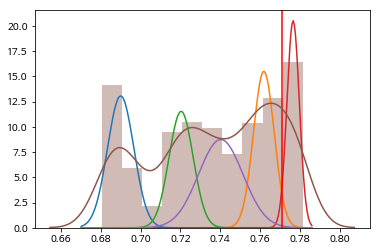

In [19]:
# cv2.destroyAllWindows()       
mask, box
preds_dist = textureDetect(rois_gt_closest, filter_size=(3,3), stride=(.25, .25))
# boundary, gmm = plotGMM(rois_gt_closest[preds_gt_closest[0]], n_components=5, SHOW_PLOT=True)
boundary, gmm = plotGMM(preds_dist[targets_gt[0]], n_components=5, SHOW_PLOT=True)

In [427]:
r = rois[1:4].detach().clone()
b = torchvision.ops.roi_align(r, [torch.tensor([[1,1,2,2.],[1,1,2,5]]).cuda()]*3, [3,3])
c = torchvision.ops.roi_align(r, [torch.tensor([[1,1,2,2.],[1,1,2,5],[1,1,2,2.],[1,1,2,5],[1,1,2,2.],[1,1,2,5]]).cuda()], [3,3])
print(r.shape, b.shape)
[aa.mean().item() for aa in b], [aa.mean().item() for aa in c]



torch.Size([3, 2048, 7, 7]) torch.Size([6, 2048, 3, 3])


([0.49775442481040955,
  0.5186532139778137,
  0.2721569538116455,
  0.31500551104545593,
  0.24221356213092804,
  0.29980188608169556],
 [0.49775442481040955,
  0.5186532139778137,
  0.49775442481040955,
  0.5186532139778137,
  0.49775442481040955,
  0.5186532139778137])

In [434]:
bb = b.reshape(3,2,2048,3,3)
print(bb.shape)
[aa.mean().item() for aa in bb]
for x in bb:
    for xx in x:
        print(xx.mean().item())

torch.Size([3, 2, 2048, 3, 3])
0.49775442481040955
0.5186532139778137
0.2721569538116455
0.31500551104545593
0.24221356213092804
0.29980188608169556


In [529]:
def textureDetect(featuremaps, filter_size=(3,3), stride=(1,1)):
    """
    box maker
    featuremaps - n X 2048 X 7 X 7
    batch n - featuremaps.shape[0]
    num_box t - len(boxes_t) = 14*14 stride=0.5
    """
    # upsample featuremap
    boxes_t = []
    # x,y 순서 바뀌면 안됨
    y_range = np.arange(0,featuremaps.shape[2], stride[0]).clip(0,featuremaps.shape[2]-1)
    x_range = np.arange(0,featuremaps.shape[3], stride[0]).clip(0,featuremaps.shape[3]-1)
    for y in y_range:
        for x in x_range:
            xx = x-((filter_size[0]-1)/2)
            yy = y-((filter_size[1]-1)/2)
            ww = filter_size[0]
            hh = filter_size[1]
            boxes_t.append([xx,yy,xx+ww,yy+hh]) # x,y,x2,y2

    boxes_t = torch.tensor(boxes_t).data.cuda().float()
    print('aaa', featuremaps.shape) # n X 2048 X 7 X 7
    print('[n_box]:', len(boxes_t)) # t
    crops = torchvision.ops.roi_align(featuremaps, [boxes_t]*featuremaps.shape[0], [1,1]).data
    # n*t X 2048 X 1 X 1
    print('bbb', crops.squeeze().shape) # n*t X 2048
    print('ccc', crops.squeeze().reshape(featuremaps.shape[0], len(boxes_t), -1).shape) # n X t X 2048 
    
    # inference
    preds_dist = my_cos(crops.squeeze(), model.embedded_means) # n*t X 31
    preds_dist = preds_dist.transpose(1,0).reshape(featuremaps.shape[0], -1, len(y_range), len(x_range)) # n X 31 X 14 X 14
    return preds_dist

In [474]:
model.predicts_dist.shape, model.predicts.shape, 43*196, 14*14, 
dp[:,0], preds_gt, preds_gt_closest

(tensor([28, 12, 28,  4,  4, 28, 24, 28, 24, 12, 12, 12, 12, 28, 12, 28, 12, 28,
         24, 24, 24, 12, 28, 12, 28, 24, 12, 24, 12,  4, 24, 24, 24, 24, 12, 12,
          4, 28, 12, 12, 12, 28, 28]),
 tensor([[28, 14, 30]], device='cuda:0'),
 tensor([[28, 15, 14]], device='cuda:0'))

In [505]:
print(dp.mean(dim=[2,3]).shape)
# for d in dp.mean(dim=[2,3]):
#     print(d.argmax().item())
m = dp.mean(dim=[2,3]).argmax(dim=1)
m.shape, m

torch.Size([43, 31])


(torch.Size([43]),
 tensor([ 6, 10, 22, 23,  3, 29, 27,  4,  8, 12,  3,  1, 13, 25,  2,  6, 18, 30,
          0, 19, 23,  0,  4, 16, 28,  5,  9, 21,  4, 16, 28, 26,  9,  7, 11, 12,
          8, 12, 24, 27,  5, 17, 29], device='cuda:0'))

Wall time: 20 ms


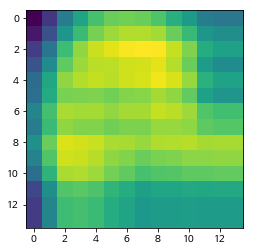

In [523]:
dp.shape,
# for i,e in enumerate(m):
#     print(dp[i,e].shape)
%time p = torch.stack([dp[i,e] for i,e in enumerate(m)])[24]
plt.imshow(p.cpu())
plt.show()

In [484]:
%time dp = textureDetect(rois, filter_size=(3,3), stride=(.5, .5), knn=True)
dp.shape

aaa torch.Size([43, 2048, 7, 7])
[n_box]: 196
bbb torch.Size([8428, 2048])
ccc torch.Size([43, 196, 2048])
Wall time: 31 ms


torch.Size([43, 31, 14, 14])

In [537]:
preds_dist.shape

torch.Size([31, 91, 52])

aaa torch.Size([1, 2048, 30, 17])
bbb torch.Size([4732, 2048])
ccc torch.Size([1, 4732, 2048])
ddd torch.Size([4732, 31])
[n_box]: 4732
Wall time: 35 ms
torch.return_types.sort(
values=tensor([0.5318, 0.5263, 0.5260, 0.5252, 0.5243, 0.5223, 0.5145, 0.5132, 0.5127,
        0.5113, 0.5093, 0.5056, 0.5015, 0.5001, 0.4983, 0.4960, 0.4941, 0.4932,
        0.4928, 0.4861, 0.4850, 0.4839, 0.4832, 0.4808, 0.4805, 0.4789, 0.4773,
        0.4768, 0.4733, 0.4731, 0.4547], device='cuda:0'),
indices=tensor([22,  4, 15, 30,  0, 10, 28, 16, 29, 11, 12, 23, 18, 14, 25,  1,  9, 27,
         2, 13, 24, 20, 26, 19,  3,  7, 21,  5,  8, 17,  6], device='cuda:0'))


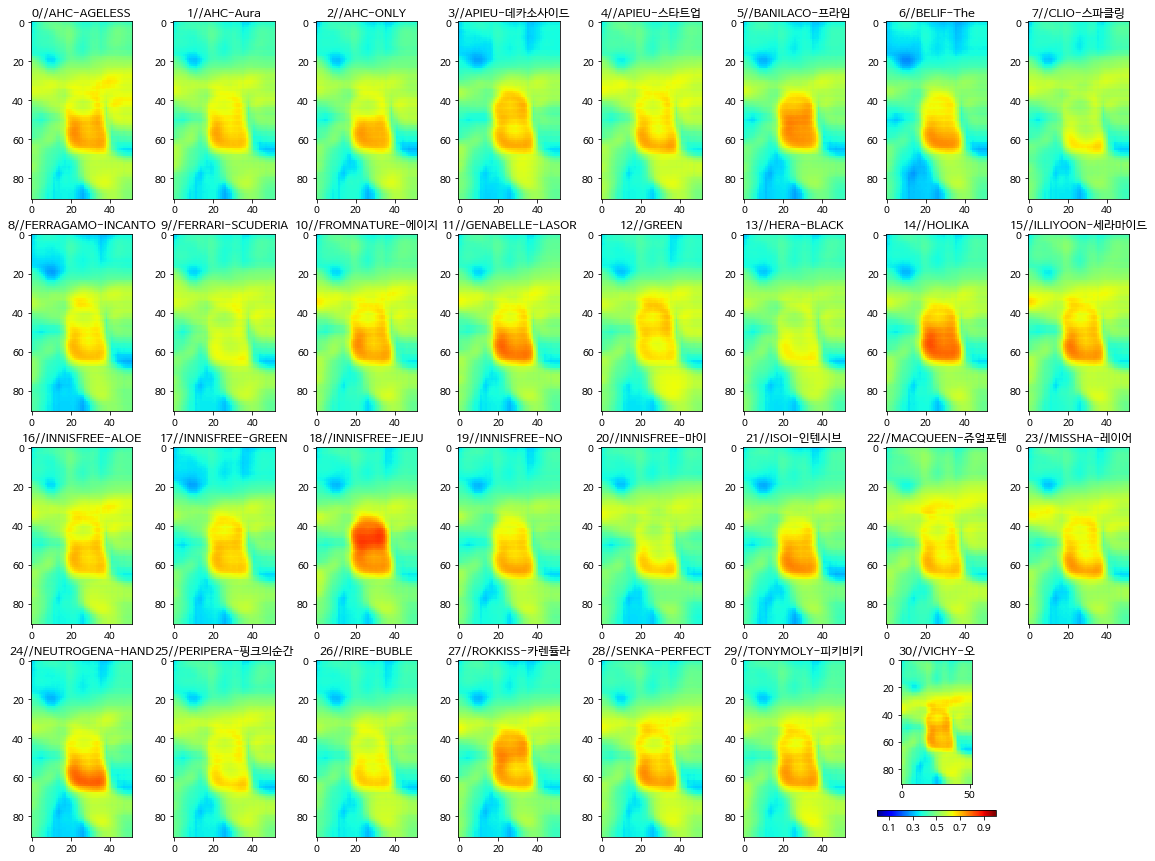

In [69]:
%time preds_dist = textureDetect(featuremaps, filter_size=(3,3), stride=(.33, .33))
# %time preds_dist = textureDetect(rois_gt, filter_size=(3,3), upsample=True, upsample_scale=3)
# %time preds_dist = textureDetect(rois_gt, filter_size=(3,3), stride=(.5, .5))
print(preds_dist.reshape(31, -1).mean(dim=1).sort(descending=True))
plotHeatMap(preds_dist[0])

18 INNISFREE-JEJU CHERRY BLOSSOM SKIN


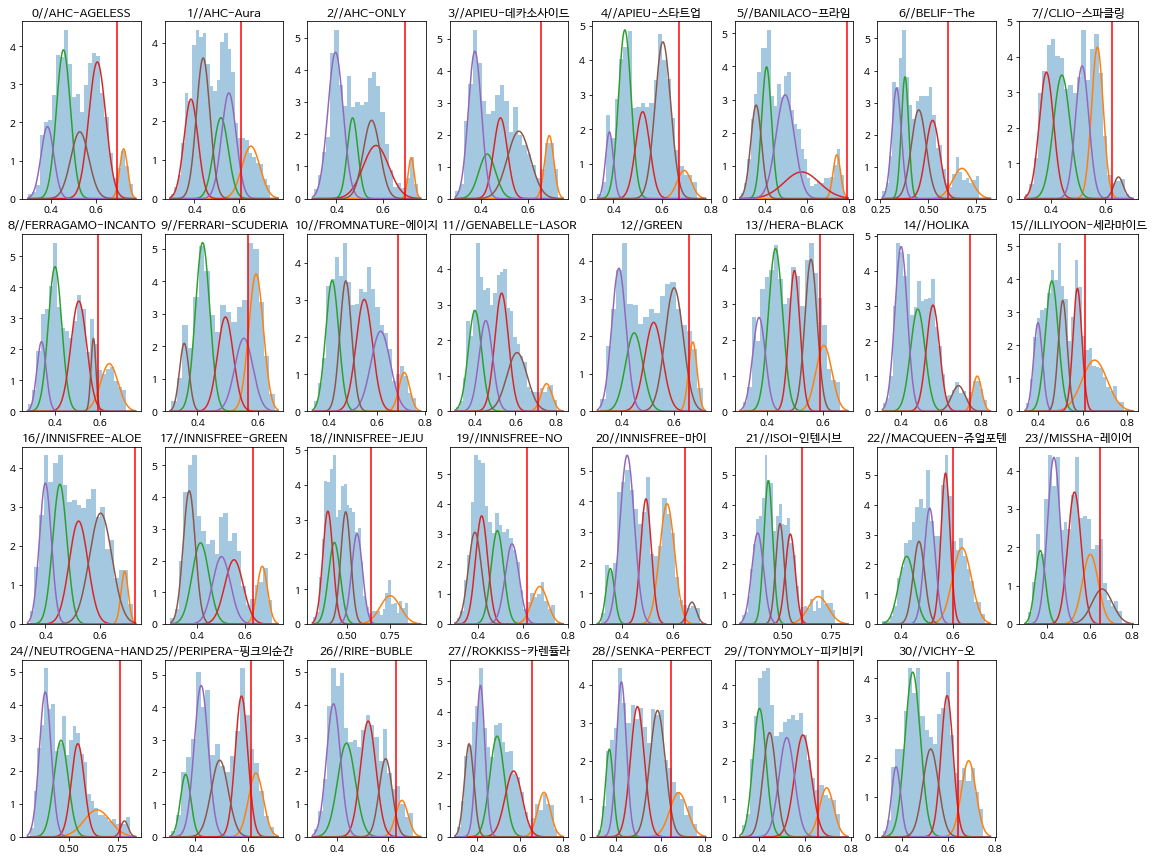

In [70]:
plt.figure(figsize=(20,15))
print(targets_gt[0], voc_val_dataset.classes[targets_gt[0]])
for i in range(31):
    plt.subplot(4,8,i+1)
    plt.title(str(i) + '//' + voc_val_dataset.classes[i].split(' ')[0])    
    sns.distplot(preds_dist[i].flatten().cpu().numpy(), kde=False, norm_hist=True)#, bins=100)
    plotGMM(preds_dist[i], n_components=5)
plt.show()


In [54]:
x_range = np.arange(0,rois_gt[1:2].shape[3], .25)#.clip(0,rois_gt[0].shape[3]-1)
rois.shape, preds.shape, boxes_cuda

(torch.Size([4, 2048, 7, 7]),
 torch.Size([4, 3]),
 tensor([[115., 408., 227., 325.],
         [115., 363., 330., 381.],
         [217., 361., 133., 317.],
         [173., 308., 314., 412.]], device='cuda:0'))

aaa torch.Size([1, 2048, 7, 7])
bbb torch.Size([784, 2048])
ccc torch.Size([1, 784, 2048])
ddd torch.Size([784, 31])
[n_box]: 784
[0.52486293 0.7620297 ] [ 0.28531002 -0.2998107 ]


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


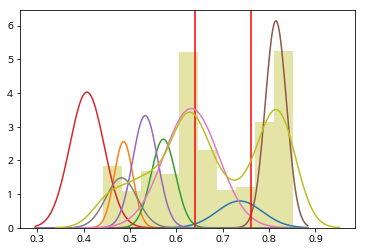

[boundary]: 0.762


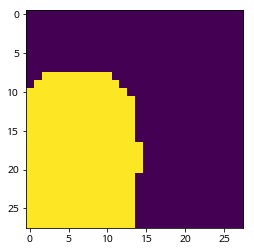

<<>> [[264 484  82 192]] (168, 855, 273, 1119)
aaa torch.Size([1, 2048, 7, 7])
bbb torch.Size([784, 2048])
ccc torch.Size([1, 784, 2048])
ddd torch.Size([784, 31])
[n_box]: 784
[0.60644882 0.64837835 0.72624747] [ 1.57242162  0.84459333 -0.36122591]


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


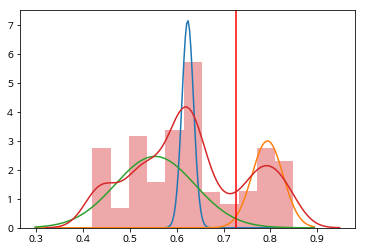

[boundary]: 0.726


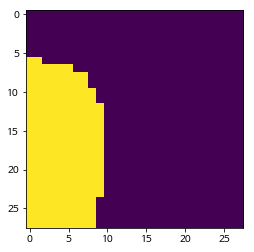

<<>> [[264 484  82 192]] (275, 708, 272, 1266)
aaa torch.Size([1, 2048, 7, 7])
bbb torch.Size([784, 2048])
ccc torch.Size([1, 784, 2048])
ddd torch.Size([784, 31])
[n_box]: 784
[0.49828857 0.59392739 0.80351884] [-0.94241341  1.21732494 -0.52614327]


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


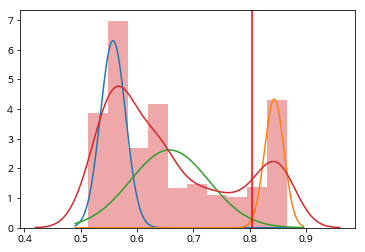

[boundary]: 0.804


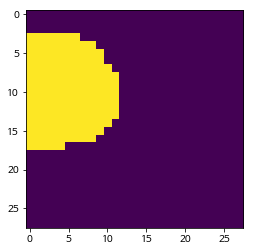

<<>> [[264 484  82 192]] (231, 489, 272, 754)
aaa torch.Size([1, 2048, 7, 7])
bbb torch.Size([784, 2048])
ccc torch.Size([1, 784, 2048])
ddd torch.Size([784, 31])
[n_box]: 784
[0.55169383 0.77640943] [0.44248003 0.7569245 ]


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


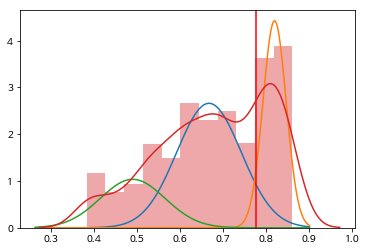

[boundary]: 0.776


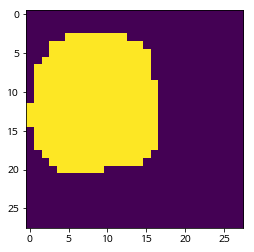

<<>> [[264 484  82 192]] (96, 576, 361, 886)
aaa torch.Size([1, 2048, 7, 7])
bbb torch.Size([784, 2048])
ccc torch.Size([1, 784, 2048])
ddd torch.Size([784, 31])
[n_box]: 784
[0.36820802 0.42121519 0.77371285] [-2.17591221 -0.71586186  0.42029181]


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


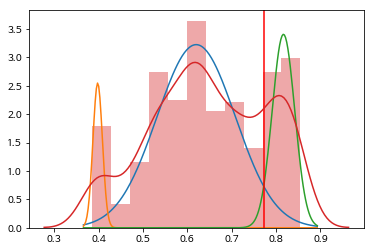

[boundary]: 0.774


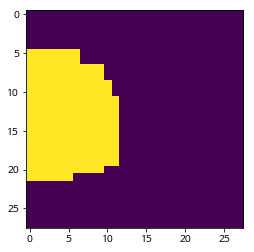

<<>> [[264 484  82 192]] (228, 663, 300, 872)
aaa torch.Size([1, 2048, 7, 7])
bbb torch.Size([784, 2048])
ccc torch.Size([1, 784, 2048])
ddd torch.Size([784, 31])
[n_box]: 784
[0.51956778 0.71586321] [0.53860292 0.02355996]


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


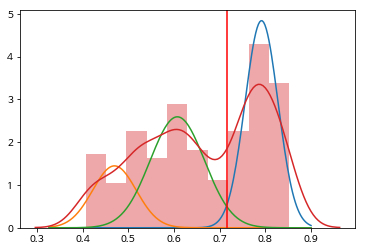

[boundary]: 0.716


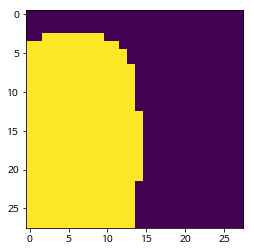

<<>> [[264 484  82 192]] (183, 563, 347, 1411)
aaa torch.Size([1, 2048, 7, 7])
bbb torch.Size([784, 2048])
ccc torch.Size([1, 784, 2048])
ddd torch.Size([784, 31])
[n_box]: 784
[0.60683196 0.80899563 0.86832627] [ 0.07884746 -0.04853735 -1.65793342]


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


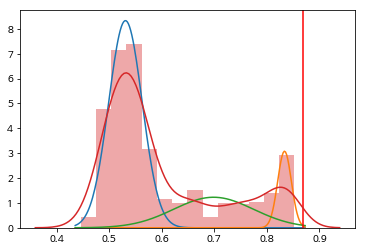

[boundary]: 0.868


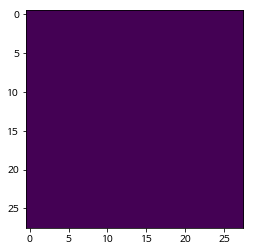

cannot convert float infinity to integer
aaa torch.Size([1, 2048, 7, 7])
bbb torch.Size([784, 2048])
ccc torch.Size([1, 784, 2048])
ddd torch.Size([784, 31])
[n_box]: 784
[0.43880382 0.47088415 0.75731561] [-1.65577895 -1.01155129  0.53499348]


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


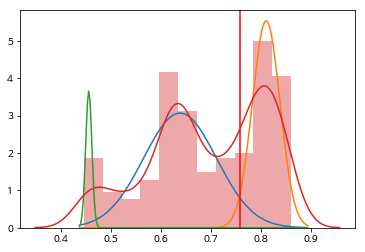

[boundary]: 0.757


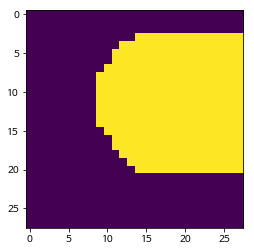

<<>> [[264 484  82 192]] (65, 538, 323, 924)
aaa torch.Size([1, 2048, 7, 7])
bbb torch.Size([784, 2048])
ccc torch.Size([1, 784, 2048])
ddd torch.Size([784, 31])
[n_box]: 784
[0.52848675 0.75680639] [-0.74282534  0.59027136]


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


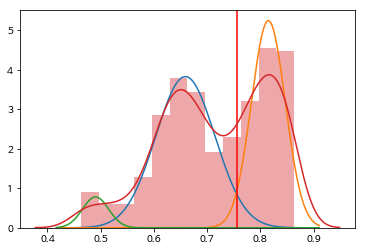

[boundary]: 0.757


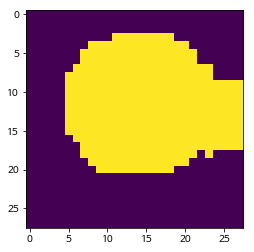

<<>> [[264 484  82 192]] (64, 518, 304, 944)
aaa torch.Size([1, 2048, 7, 7])
bbb torch.Size([784, 2048])
ccc torch.Size([1, 784, 2048])
ddd torch.Size([784, 31])
[n_box]: 784
[0.52269804 0.69824066] [-0.62884751  0.18662439]


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


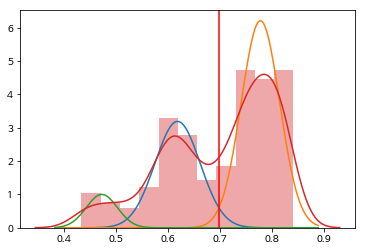

[boundary]: 0.698


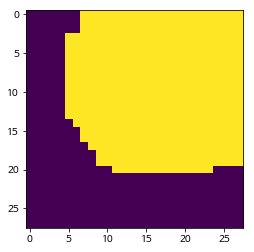

<<>> [[264 484  82 192]] (112, 427, 432, 1035)
aaa torch.Size([1, 2048, 7, 7])
bbb torch.Size([784, 2048])
ccc torch.Size([1, 784, 2048])
ddd torch.Size([784, 31])
[n_box]: 784
[0.3828124  0.4064747  0.64046856] [-0.786808   -0.46442641 -0.84109212]


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


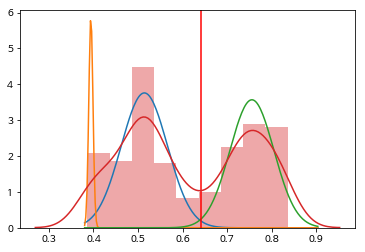

[boundary]: 0.64


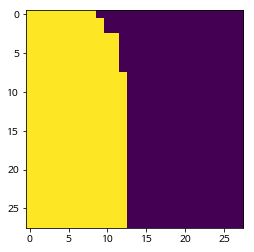

<<>> [[264 484  82 192]] (253, 408, 411, 1566)
aaa torch.Size([1, 2048, 7, 7])
bbb torch.Size([784, 2048])
ccc torch.Size([1, 784, 2048])
ddd torch.Size([784, 31])
[n_box]: 784
[0.33130615 0.33976789 0.7149049 ] [ 1.38120856 -0.5795545  -0.48693046]


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


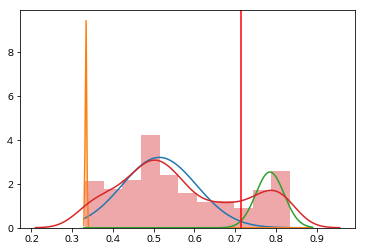

[boundary]: 0.715


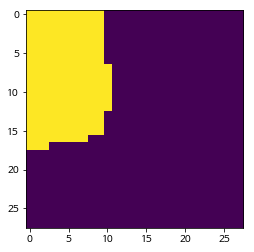

<<>> [[264 484  82 192]] (263, 482, 484, 761)
aaa torch.Size([1, 2048, 7, 7])
bbb torch.Size([784, 2048])
ccc torch.Size([1, 784, 2048])
ddd torch.Size([784, 31])
[n_box]: 784
[0.64784146 0.74307279] [0.91006396 0.41499586]


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


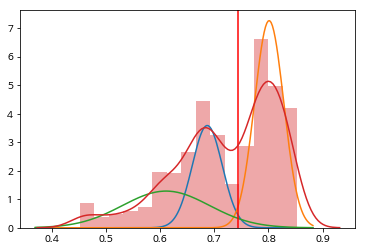

[boundary]: 0.743


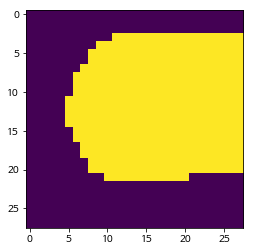

<<>> [[264 484  82 192]] (114, 554, 340, 981)
aaa torch.Size([1, 2048, 7, 7])
bbb torch.Size([784, 2048])
ccc torch.Size([1, 784, 2048])
ddd torch.Size([784, 31])
[n_box]: 784
[0.63388079 0.77978865 0.81166767] [-0.81353337  1.98032321  0.21721692]


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


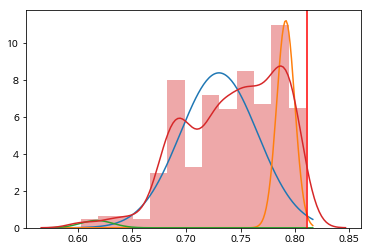

[boundary]: 0.812


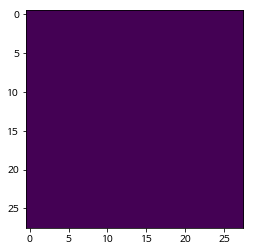

cannot convert float infinity to integer
aaa torch.Size([1, 2048, 7, 7])
bbb torch.Size([784, 2048])
ccc torch.Size([1, 784, 2048])
ddd torch.Size([784, 31])
[n_box]: 784
[0.68628799 0.83320543 0.87984589] [-0.49170578  0.70896767 -1.25257786]


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


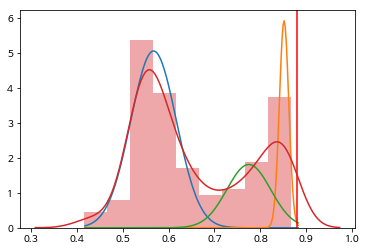

[boundary]: 0.88


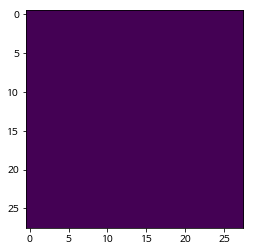

cannot convert float infinity to integer
aaa torch.Size([1, 2048, 7, 7])
bbb torch.Size([784, 2048])
ccc torch.Size([1, 784, 2048])
ddd torch.Size([784, 31])
[n_box]: 784
[0.65699133 0.7731092 ] [0.13496902 1.15353321]


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


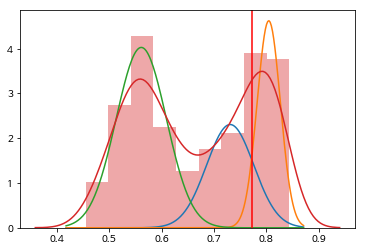

[boundary]: 0.773


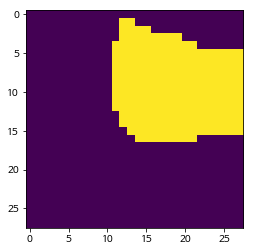

<<>> [[264 484  82 192]] (7, 534, 465, 636)
aaa torch.Size([1, 2048, 7, 7])
bbb torch.Size([784, 2048])
ccc torch.Size([1, 784, 2048])
ddd torch.Size([784, 31])
[n_box]: 784
[0.48614502 0.59691844 0.81194919 0.88579814] [ 0.54946513  0.97336144 -0.51982771 -1.96435209]


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


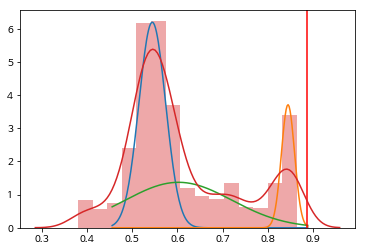

[boundary]: 0.886


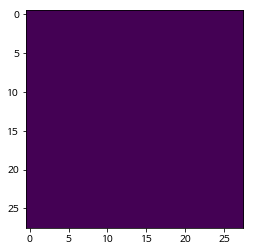

cannot convert float infinity to integer
aaa torch.Size([1, 2048, 7, 7])
bbb torch.Size([784, 2048])
ccc torch.Size([1, 784, 2048])
ddd torch.Size([784, 31])
[n_box]: 784
[0.70717552 0.83194195 0.89305204] [ 0.46522552  0.66783286 -1.9441016 ]


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


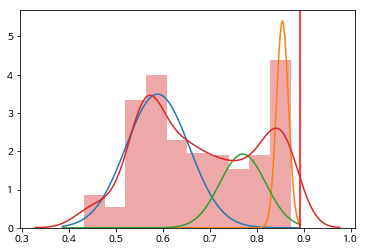

[boundary]: 0.893


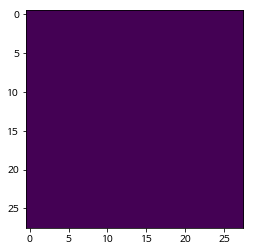

cannot convert float infinity to integer
aaa torch.Size([1, 2048, 7, 7])
bbb torch.Size([784, 2048])
ccc torch.Size([1, 784, 2048])
ddd torch.Size([784, 31])
[n_box]: 784
[0.55061315 0.78219751 0.8423493 ] [-0.68360005  0.53584868 -1.86494834]


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


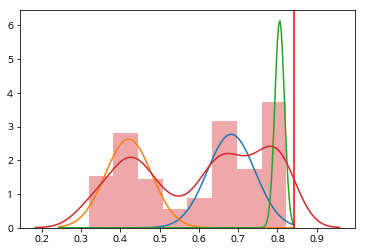

[boundary]: 0.842


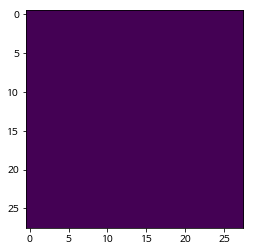

cannot convert float infinity to integer
aaa torch.Size([1, 2048, 7, 7])
bbb torch.Size([784, 2048])
ccc torch.Size([1, 784, 2048])
ddd torch.Size([784, 31])
[n_box]: 784
[0.52569896 0.75874767] [0.87760846 0.21810021]


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


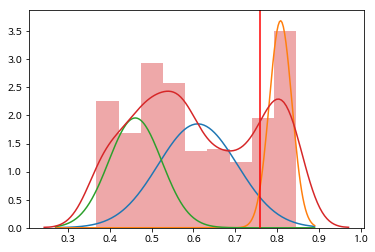

[boundary]: 0.759


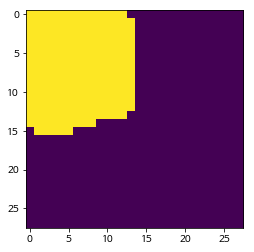

<<>> [[264 484  82 192]] (183, 480, 483, 617)
aaa torch.Size([1, 2048, 7, 7])
bbb torch.Size([784, 2048])
ccc torch.Size([1, 784, 2048])
ddd torch.Size([784, 31])
[n_box]: 784
[0.61940782 0.80182624 0.8365726 ] [-0.89419296  1.22611262 -0.25909286]


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


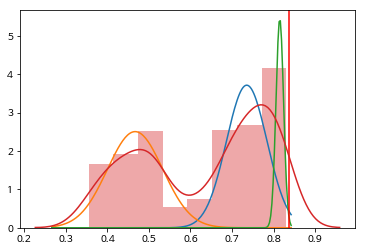

[boundary]: 0.837


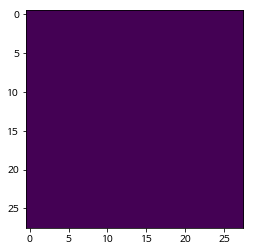

cannot convert float infinity to integer
aaa torch.Size([1, 2048, 7, 7])
bbb torch.Size([784, 2048])
ccc torch.Size([1, 784, 2048])
ddd torch.Size([784, 31])
[n_box]: 784
[0.38770835 0.40610105 0.66622637] [-0.90169729 -1.06738706 -0.87452133]


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


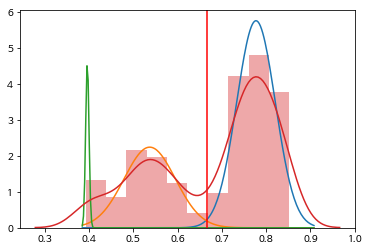

[boundary]: 0.666


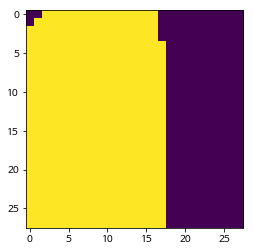

<<>> [[264 484  82 192]] (96, 408, 412, 1566)
aaa torch.Size([1, 2048, 7, 7])
bbb torch.Size([784, 2048])
ccc torch.Size([1, 784, 2048])
ddd torch.Size([784, 31])
[n_box]: 784
[0.65215692 0.78070187 0.82744548] [ 0.20215812  1.77163924 -1.04718568]


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


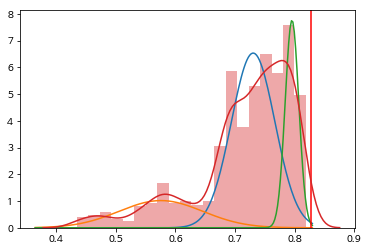

[boundary]: 0.827


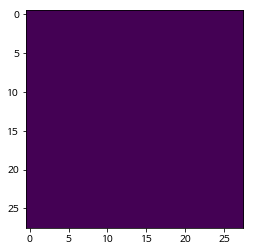

cannot convert float infinity to integer
aaa torch.Size([1, 2048, 7, 7])
bbb torch.Size([784, 2048])
ccc torch.Size([1, 784, 2048])
ddd torch.Size([784, 31])
[n_box]: 784
[0.61902887 0.80005557] [ 0.45353132 -0.53377255]


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


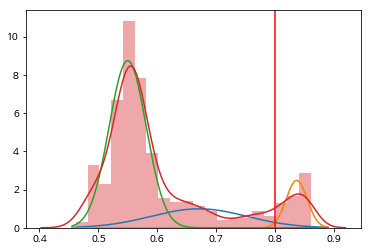

[boundary]: 0.8


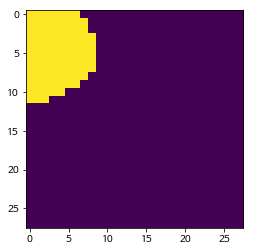

<<>> [[264 484  82 192]] (276, 409, 411, 395)
aaa torch.Size([1, 2048, 7, 7])
bbb torch.Size([784, 2048])
ccc torch.Size([1, 784, 2048])
ddd torch.Size([784, 31])
[n_box]: 784
[0.61566701 0.76566891 0.81957585] [ 0.17214932  1.43013976 -1.32571766]


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


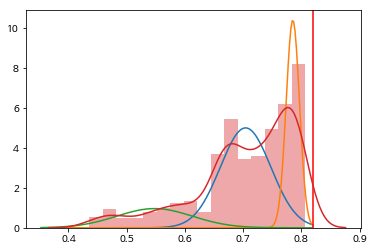

[boundary]: 0.82


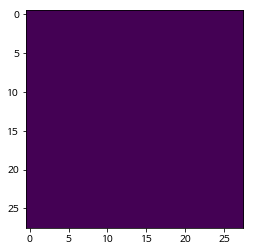

cannot convert float infinity to integer
aaa torch.Size([1, 2048, 7, 7])
bbb torch.Size([784, 2048])
ccc torch.Size([1, 784, 2048])
ddd torch.Size([784, 31])
[n_box]: 784
[0.60427797 0.74546748] [0.0411565 1.1015344]


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


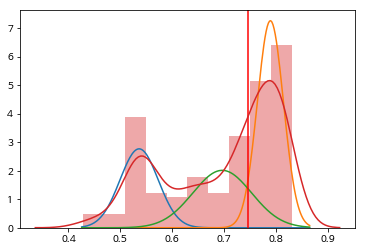

[boundary]: 0.745


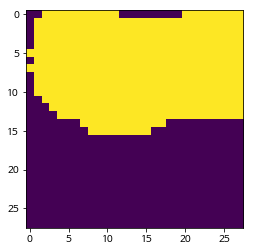

<<>> [[264 484  82 192]] (182, 482, 488, 615)
aaa torch.Size([1, 2048, 7, 7])
bbb torch.Size([784, 2048])
ccc torch.Size([1, 784, 2048])
ddd torch.Size([784, 31])
[n_box]: 784
[0.41332159 0.67040115] [ 0.0813892  -0.69887992]


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


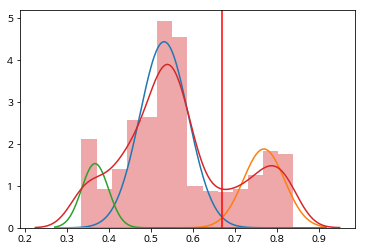

[boundary]: 0.67


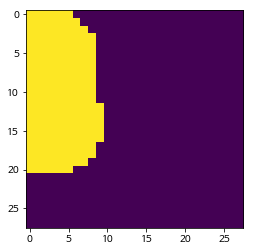

<<>> [[264 484  82 192]] (296, 407, 409, 1055)
aaa torch.Size([1, 2048, 7, 7])
bbb torch.Size([784, 2048])
ccc torch.Size([1, 784, 2048])
ddd torch.Size([784, 31])
[n_box]: 784
[0.64802252 0.77502637 0.80854127] [0.28796729 1.4400839  0.02100312]


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


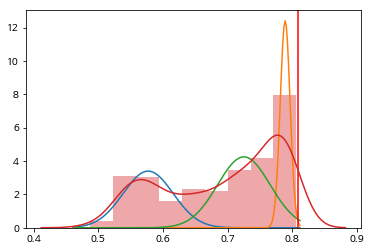

[boundary]: 0.809


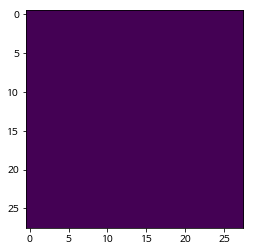

cannot convert float infinity to integer


In [62]:
for i,r in enumerate(rois):
    preds_dist = textureDetect(r.unsqueeze(0), filter_size=(3,3), stride=(.25, .25))

    boundary, gmm = plotGMM(preds_dist[targets_gt[0]], n_components=3, SHOW_PLOT=True)
    print('[boundary]:', boundary)

    mask = preds_dist[targets_gt[0]]#.cpu().numpy().clip(boundary,1)
    mask = torch.where(mask>boundary, torch.zeros_like(mask).fill_(255), torch.zeros_like(mask))

    plt.imshow(mask.cpu().numpy())
    plt.show()
    # print(mask.shape)
    box = getOrdi(mask, 255) # x1, y1, x2, y2
    x1, y1, x2, y2 = box
    r_y = r.shape[0]/mask.shape[0]
    r_x = r.shape[1]/mask.shape[1]
    x1*=r_x; x2*=r_x; y1*=r_y; y2*=r_y
    x1 += boxes_cuda[i][0]; x2 += boxes_cuda[i][0]; y1 += boxes_cuda[i][1]; x2 += boxes_cuda[i][1]
    try:
        print('<<>>', boxes_gt, (int(x1), int(y1), int(x2-x1), int(y2-y1)))
        cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 0, 255), 1, cv2.LINE_AA)
    except Exception as e: print(e)
        
cv2.imshow('frame',frame)
cv2.waitKey(0)
cv2.destroyAllWindows()      

[0.41947254 0.46349229 0.53266617 0.63957126] [ 1.49232255  1.22368445  1.15027398 -1.44206411]


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


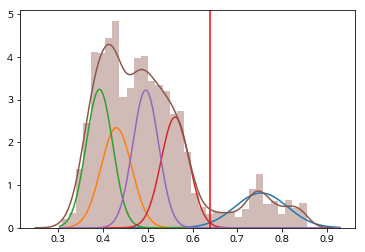

Wall time: 283 ms


In [68]:
%%time
from sklearn.mixture import GaussianMixture
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import scipy.stats as stats
import math

def getOrdi(mask, boundary):
    """
    max/min x,y 좌표 구하기
    """
    mask_list = mask.tolist()
    mask_T_list = mask.T.tolist()
    # x1, y1, x2, y2
    x1 = float('inf')
    x2 = float('-inf')
    y1 = float('inf')
    y2 = float('-inf')

    for row in mask_list:
        try:
            xmin = row.index(boundary)
            xmax = len(row)-row[::-1].index(boundary)-1
            if x1>xmin: x1=xmin
            if x2<xmax: x2=xmax
        except: pass
    for row in mask_T_list:
        try:
            xmin = row.index(boundary)
            xmax = len(row)-row[::-1].index(boundary)-1
            if y1>xmin: y1=xmin
            if y2<xmax: y2=xmax        
        except: pass
    return x1, y1, x2, y2

def plotGMM(inputs, n_components=5, SHOW_PLOT=False):
    """
    inputs - preds_dist[c_idx]
    """
    X = inputs.flatten().reshape(-1,1).cpu()
    # fit GMM
    gmm = GaussianMixture(n_components=n_components, init_params='kmeans', random_state=0, tol=1e-9)#, max_iter=n)
    with ignore_warnings(category=ConvergenceWarning):
        gmm.fit(X)

    y=[]
    i_max = gmm.means_.argmax()
    i_min = gmm.means_.argmin()
    mu_max = gmm.means_[i_max][0]
    std_max = math.sqrt(gmm.covariances_[i_max][0])
    mu_min = gmm.means_[i_min][0]
    std_min = math.sqrt(gmm.covariances_[i_min][0])
    x = np.linspace(mu_min - 3*std_min, mu_max + 3*std_max, 200) # get x range 중요.
    for i in range(n_components):
        mu = gmm.means_[i][0]
        var = gmm.covariances_[i][0]
        sigma = math.sqrt(var)
#         x = np.linspace(0.3,0.9,200)
        y.append(stats.norm.pdf(x, mu, sigma)*gmm.weights_[i])
        plt.plot(x, y[i])
#         x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
#         y.append(x)
#         plt.plot(x, stats.norm.pdf(x, mu, sigma)*gmm.weights_[i])
    # find decision boundary
    k = gmm.predict(x.reshape(-1,1))
    idx = np.where(np.abs(k[1:]-k[:-1])!=0) # 두 responsibility가 교체되는 x값의 인덱스
#     print(np.abs(k[1:]-k[:-1])!=0, idx)
    boundaries = x[1:][idx]
#     # boundaries 가 여러개 나올 수 있는데 그 중 likelihood가 가장 높은 값의 인덱스 선택
#     b_idx = gmm.score_samples(boundaries.reshape(-1,1)).argmax()  
#     boundary = boundaries[b_idx]
    # boundaries 가 여러개 나올 수 있는데 그 중 score 0.05이상의 가장 큰 값 선택
    boundary = boundaries[gmm.score_samples(boundaries.reshape(-1,1))>np.log(0.05)][-1]
    plt.axvline(x=boundary, c='r') 
    
    if(SHOW_PLOT):
        print(boundaries, gmm.score_samples(boundaries.reshape(-1,1)))
        sns.distplot(inputs.flatten().cpu().numpy())
        plt.show()
    return round(boundary, 3), gmm

_, gmm = plotGMM(preds_dist[targets_gt[0]], n_components=5, SHOW_PLOT=True)

In [12]:
# import matplotlib as mpl
# import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

font_path = 'C:\\Windows\\Fonts\\NanumBarunGothic.ttf'
font_name = fm.FontProperties(fname=font_path, size=50).get_name()
print(font_name)
plt.rc('font', family=font_name)

# font setting
font_title = {'family': 'NanumBarunGothic', 'size': 18, 'color': 'black'}
font_label = {'family': 'NanumBarunGothic', 'size': 12, 'color': 'black'}

def textureDetect(featuremaps, filter_size=(3,3), stride=(1,1)):
    """
    box maker
    batch N - featuremaps.shape[0]
    """
    # upsample featuremap
    boxes_t = []
    # x,y 순서 바뀌면 안됨
    y_range = np.arange(0,featuremaps.shape[2], stride[0]).clip(0,featuremaps.shape[2]-1)
    x_range = np.arange(0,featuremaps.shape[3], stride[0]).clip(0,featuremaps.shape[3]-1)
    for y in y_range:
        for x in x_range:
            xx = x-((filter_size[0]-1)/2)
            yy = y-((filter_size[1]-1)/2)
            ww = filter_size[0]
            hh = filter_size[1]
            boxes_t.append([xx,yy,xx+ww,yy+hh]) # x,y,x2,y2

    boxes_t = torch.tensor(boxes_t).data.cuda().float()
    print('aaa', featuremaps.shape)
    crops = torchvision.ops.roi_align(featuremaps, [boxes_t]*featuremaps.shape[0], [1,1]).data
    print('bbb', crops.squeeze().shape)
    print('ccc', crops.squeeze().reshape(featuremaps.shape[0], len(boxes_t), -1).shape)
    
    # inference
    preds_dist = my_cos(crops.squeeze(), model.embedded_means)
    print('ddd', preds_dist.shape)
#     preds_dist = model.inference_tensor4(crops)
    preds_dist = preds_dist.transpose(1,0).reshape(-1, len(y_range), len(x_range))
#     preds_dist = preds_dist.transpose(1,0).reshape(-1, featuremaps.shape[2], featuremaps.shape[3])
#     preds_reshaped = preds[:,0].reshape(featuremaps.shape[2], featuremaps.shape[3])
    print('[n_box]:', len(boxes_t))
    return preds_dist



def plotHeatMap(preds):
    fig = plt.figure(figsize=(20,15))
    for j in range(4):
        for i in range(8):
            n_fig = i+j*8+1
            if(n_fig==32):
                break
            a=fig.add_subplot(4,8,n_fig)
            imgplot = plt.imshow(preds_dist.cpu()[n_fig-1], cmap='jet')
            imgplot.set_clim(0,1)
            a.set_title(str(n_fig-1)+'//'+voc_val_dataset.classes[n_fig-1].split(' ')[0])
    plt.colorbar(ticks=[0.1,0.3,0.5,0.7,0.9], orientation ='horizontal')
    plt.show()
    return

NanumBarunGothic


---
# mean Average Precision
- 클래스별로 AP구한뒤 평균
- AP구하기 위해 실제 bbox개수(Ground truth), confidience, True postive(50% IOU) 기록
- sort by confidence
- calculate precision, recall

[class]: AHC-AGELESS REAL EYE CREAM FOR FACE , [AP]: 0.09090909090909091
[Precisions] [1 0 0 0 0 0 0 0 0 0 0]


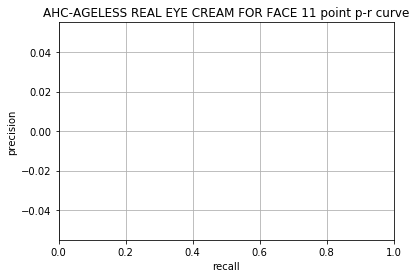

[class]: AHC-Aura Secret Toneup Cream , [AP]: 0.5194805194805195
[Precisions] [1.         1.         1.         1.         0.85714286 0.85714286
 0.         0.         0.         0.         0.        ]


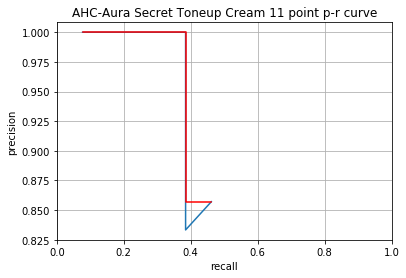

[class]: AHC-ONLY FOR MAN LOTION , [AP]: 0.3939393939393939
[Precisions] [1.         0.         0.66666667 0.66666667 0.66666667 0.66666667
 0.66666667 0.         0.         0.         0.        ]


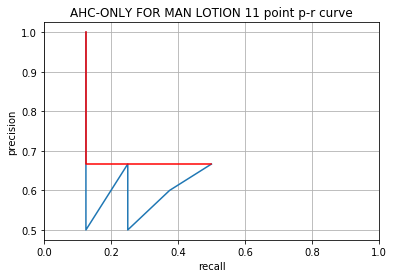

[class]: APIEU-데카소사이드 시카 겔 데이크림 , [AP]: 1.0
[Precisions] [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


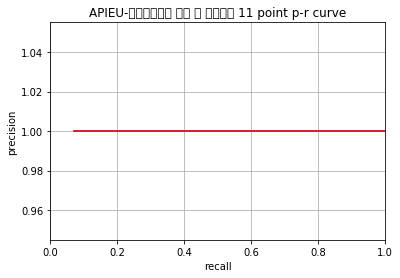

[class]: APIEU-스타트업 포어 프라이머 , [AP]: 0.09090909090909091
[Precisions] [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


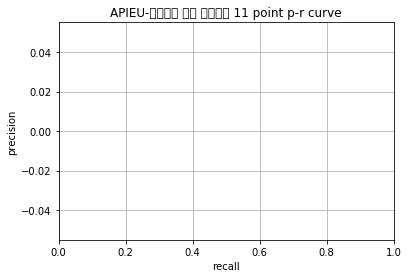

[class]: BANILACO-프라임 프라이머 클래식 , [AP]: 0.6060606060606061
[Precisions] [1.         1.         1.         1.         1.         0.83333333
 0.83333333 0.         0.         0.         0.        ]


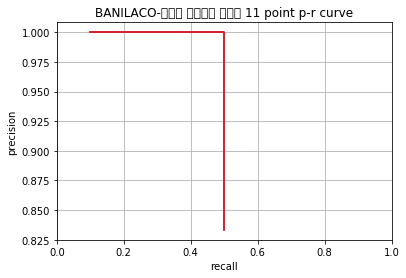

[class]: BELIF-The true cream AQUA BOMB , [AP]: 0.9025974025974026
[Precisions] [1.         1.         1.         1.         1.         1.
 1.         1.         1.         0.92857143 0.        ]


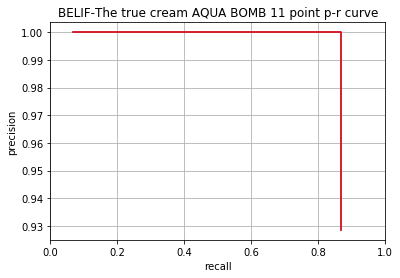

[class]: CLIO-스파클링 라인 프리즘 에어 아이섀도우 , [AP]: 0.8664540138224349
[Precisions] [1.         1.         1.         1.         1.         0.93333333
 0.93333333 0.93333333 0.88888889 0.84210526 0.        ]


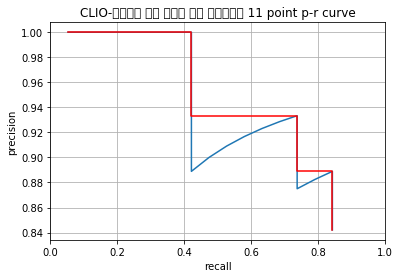

[class]: FERRAGAMO-INCANTO CHARMS , [AP]: 0.9300699300699301
[Precisions] [1.         0.92307692 0.92307692 0.92307692 0.92307692 0.92307692
 0.92307692 0.92307692 0.92307692 0.92307692 0.92307692]


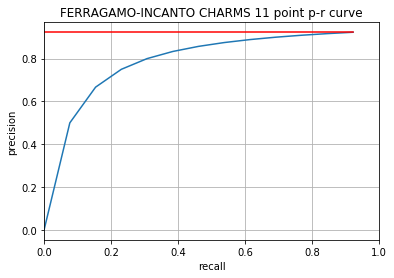

[class]: FERRARI-SCUDERIA BLACK EAU DE TOILETTE SPRAY , [AP]: 0.8481404958677686
[Precisions] [1.         1.         1.         1.         1.         1.
 0.875      0.81818182 0.81818182 0.81818182 0.        ]


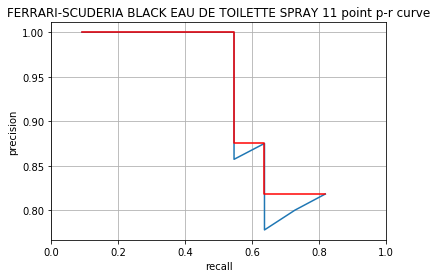

[class]: FROMNATURE-에이지 인텐스 트리트먼트 에센스 , [AP]: 0.18181818181818182
[Precisions] [1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


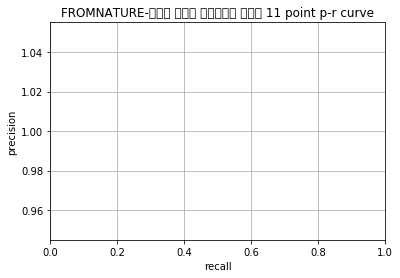

[class]: GENABELLE-LASOR SOOTHING SUNSCREEN , [AP]: 0.45454545454545453
[Precisions] [1.  1.  1.  1.  0.5 0.5 0.  0.  0.  0.  0. ]


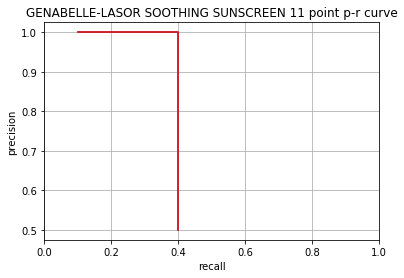

[class]: GREEN FINGER-KIDS FACIAL LOTION , [AP]: 0.36363636363636365
[Precisions] [1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0.]


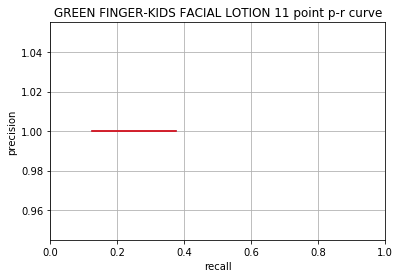

[class]: HERA-BLACK CUSHION , [AP]: 0.8454545454545456
[Precisions] [1.  1.  1.  0.9 0.9 0.9 0.9 0.9 0.9 0.9 0. ]


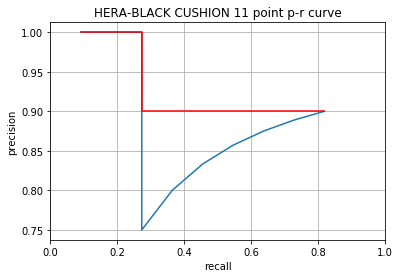

[class]: HOLIKA HOLIKA-GOOD CERA SUPER CERAMIDE MIST , [AP]: 0.09090909090909091
[Precisions] [1 0 0 0 0 0 0 0 0 0 0]


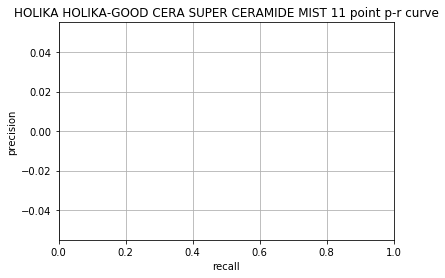

[class]: ILLIYOON-세라마이드 아토 수딩 젤 , [AP]: 0.924242424242424
[Precisions] [1.         0.91666667 0.91666667 0.91666667 0.91666667 0.91666667
 0.91666667 0.91666667 0.91666667 0.91666667 0.91666667]


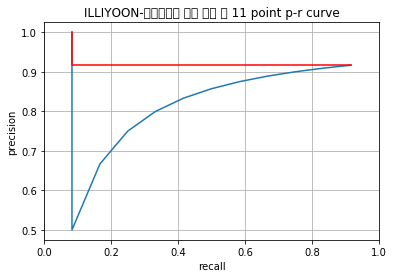

[class]: INNISFREE-ALOE REVITAL SOOTHING GEL , [AP]: 0.9090909090909091
[Precisions] [1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


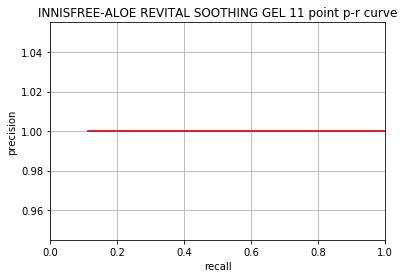

[class]: INNISFREE-GREEN TEA SEED ESSENC IN LOTION , [AP]: 0.09090909090909091
[Precisions] [1 0 0 0 0 0 0 0 0 0 0]


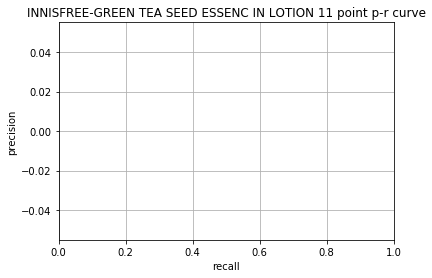

[class]: INNISFREE-JEJU CHERRY BLOSSOM SKIN , [AP]: 0.09090909090909091
[Precisions] [1 0 0 0 0 0 0 0 0 0 0]


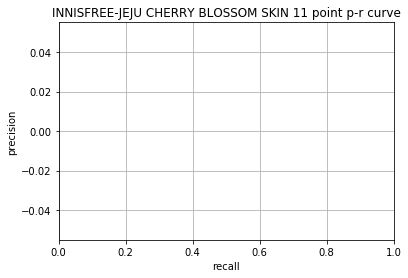

[class]: INNISFREE-NO SEBUM Mineral Powder , [AP]: 0.9590409590409592
[Precisions] [1.         1.         1.         1.         1.         1.
 0.92307692 0.92307692 0.92307692 0.92307692 0.85714286]


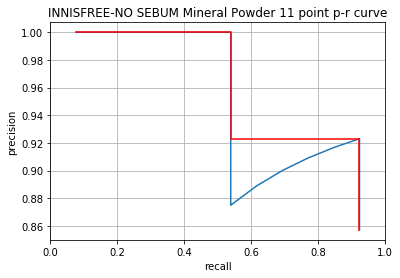

[class]: INNISFREE-마이 블러셔 햇살 가득 장미 , [AP]: 0.6082644628099174
[Precisions] [1.         1.         0.81818182 0.81818182 0.81818182 0.81818182
 0.81818182 0.6        0.         0.         0.        ]


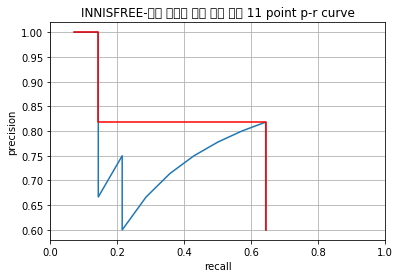

[class]: ISOI-인텐시브 에너자이징크림 , [AP]: 0.9015151515151515
[Precisions] [1.         1.         1.         1.         1.         1.
 1.         1.         1.         0.91666667 0.        ]


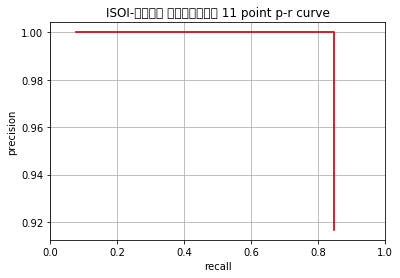

[class]: MACQUEEN-쥬얼포텐 아이글리터 , [AP]: 0.09090909090909091
[Precisions] [1 0 0 0 0 0 0 0 0 0 0]


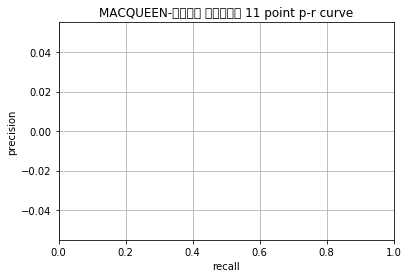

[class]: MISSHA-레이어 블러링 모공커버 프라이머 , [AP]: 0.6136363636363636
[Precisions] [1.    1.    1.    1.    1.    0.875 0.875 0.    0.    0.    0.   ]


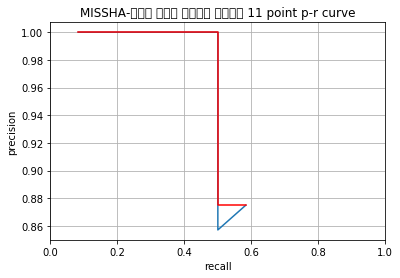

[class]: NEUTROGENA-HAND CREAM , [AP]: 0.5321428571428571
[Precisions] [1.         0.         1.         1.         0.8        0.71428571
 0.71428571 0.625      0.         0.         0.        ]


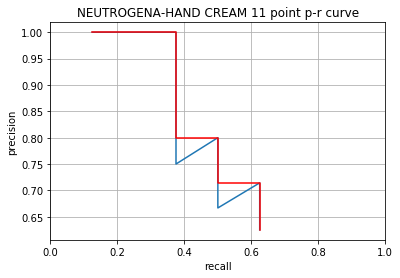

[class]: PERIPERA-핑크의순간 컬렉션 잉크 컬러 마스카라 , [AP]: 0.13636363636363635
[Precisions] [1.  0.5 0.  0.  0.  0.  0.  0.  0.  0.  0. ]


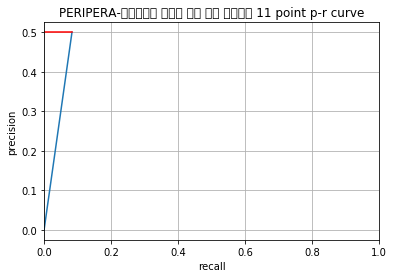

[class]: RIRE-BUBLE BUBLE LIP MASK , [AP]: 0.26136363636363635
[Precisions] [1.    0.5   0.5   0.5   0.375 0.    0.    0.    0.    0.    0.   ]


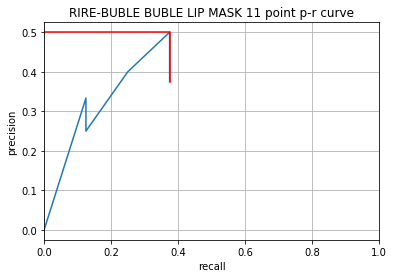

[class]: ROKKISS-카렌듈라 에멀젼 , [AP]: 0.9090909090909091
[Precisions] [1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


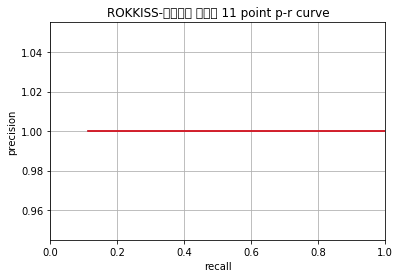

[class]: SENKA-PERFECT WHIP , [AP]: 0.7840909090909091
[Precisions] [1.    0.    1.    1.    1.    1.    1.    0.875 0.875 0.875 0.   ]


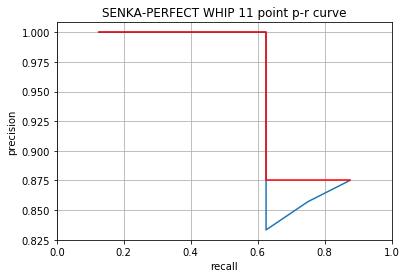

[class]: TONYMOLY-피키비키 아트 팝 코렉팅 베이스 , [AP]: 0.9545454545454544
[Precisions] [1.         1.         1.         1.         1.         0.91666667
 0.91666667 0.91666667 0.91666667 0.91666667 0.91666667]


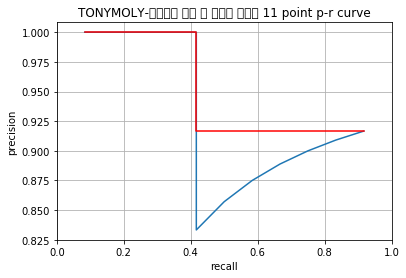

[class]: VICHY-오 떼르말 미네랄 온천수 미스트 , [AP]: 0.818417945690673
[Precisions] [1.         1.         0.90909091 0.90909091 0.90909091 0.90909091
 0.90909091 0.85714286 0.8        0.8        0.        ]


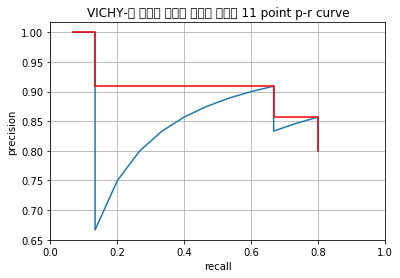

0.5732082926248692

In [87]:
from collections import Counter
# https://github.com/rafaelpadilla/Object-Detection-Metrics

def calc_AP(label):
    target = voc_val_dataset.classes.index(label)
    n_gt = Counter(target_all)

    _df = dfs[label].sort_values(by='confidience', ascending=False) # sort by conf

    _df['FP'] = [0 if tp==1 else 1 for tp in _df['TP']]
    _df['cum_TP'] = _df['TP'].cumsum()
    _df['cum_FP'] = _df['FP'].cumsum()
    _df['precision'] = [tp/(tp+fp) for tp,fp in zip(_df['cum_TP'],_df['cum_FP'])]
    _df['recall'] = _df['cum_TP']/n_gt[target]
    _df['precision_interpolated'] = [_df['precision'][i:].max() for i in range(len(_df['recall']))] 
    _df.reset_index(inplace=True)

    precisions = [_df['precision_interpolated'][_df['recall'].between(0.1*(i-1),0.1*i,inclusive=True)].min() for i in range(11)]
    precisions[0] = 1
    precisions = np.array([0 if p is np.nan else p for p in precisions])
    AP = precisions.mean()
    print('[class]:', label, ', [AP]:', AP)
    print('[Precisions]', precisions)

    plt.plot(_df['recall'], _df['precision'])
    plt.plot(_df['recall'], _df['precision_interpolated'], color='r')
    plt.grid()
    plt.xlim([0,1]), plt.title(label+' 11 point p-r curve')
    plt.xlabel('recall'), plt.ylabel('precision')
    plt.show()

    # display(_df)
    return AP, _df
    
# AP_list = np.array([calc_AP(t)[0] for t in voc_val_dataset.classes])

AP_list = []
df_res_list = {}
for cls in voc_val_dataset.classes:
    AP, df_res = calc_AP(cls)
    AP_list.append(AP)
    df_res_list[cls] = df_res
AP_list = np.array(AP_list)

mAP = AP_list.mean()
mAP

In [118]:
list(zip(voc_val_dataset.classes, AP_list))

[('AHC-AGELESS REAL EYE CREAM FOR FACE', 0.1250971250971251),
 ('AHC-Aura Secret Toneup Cream', 0.40735930735930737),
 ('AHC-ONLY FOR MAN LOTION', 0.2845585036972597),
 ('APIEU-데카소사이드 시카 겔 데이크림', 0.4669421487603305),
 ('APIEU-스타트업 포어 프라이머', 0.18181818181818182),
 ('BANILACO-프라임 프라이머 클래식', 0.36451048951048953),
 ('BELIF-The true cream AQUA BOMB', 0.7272727272727273),
 ('CLIO-스파클링 라인 프리즘 에어 아이섀도우', 0.19090909090909092),
 ('FERRAGAMO-INCANTO CHARMS', 1.0),
 ('FERRARI-SCUDERIA BLACK EAU DE TOILETTE SPRAY', 0.36576999945983907),
 ('FROMNATURE-에이지 인텐스 트리트먼트 에센스', 0.2727272727272727),
 ('GENABELLE-LASOR SOOTHING SUNSCREEN', 0.7272727272727273),
 ('GREEN FINGER-KIDS FACIAL LOTION', 0.9090909090909091),
 ('HERA-BLACK CUSHION', 0.7987012987012988),
 ('HOLIKA HOLIKA-GOOD CERA SUPER CERAMIDE MIST', 0.2897727272727273),
 ('ILLIYOON-세라마이드 아토 수딩 젤', 0.49090909090909096),
 ('INNISFREE-ALOE REVITAL SOOTHING GEL', 0.993939393939394),
 ('INNISFREE-GREEN TEA SEED ESSENC IN LOTION', 0.4696969696969697),
 (

In [119]:
from IPython.core.display import HTML
tps = []
fps = []
for k in df_res_list:
#     display(HTML(df_res_list[k].to_html()))
    try:
        tps.append(list(df_res_list[k]['cum_TP'])[-1])
        fps.append(list(df_res_list[k]['cum_FP'])[-1])
    except:
        tps.append(np.nan)
        fps.append(np.nan)

In [97]:
# tps2=tps
# fps2=fps
# AP_list_front = AP_list

In [55]:
# import matplotlib as mpl
# import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

font_path = 'C:\\Windows\\Fonts\\NanumBarunGothic.ttf'
font_name = fm.FontProperties(fname=font_path, size=50).get_name()
print(font_name)
plt.rc('font', family=font_name)

# plot위해 클래스 이름 줄이기
class_trun = [c.split('-')[0] for c in voc_val_dataset.classes]

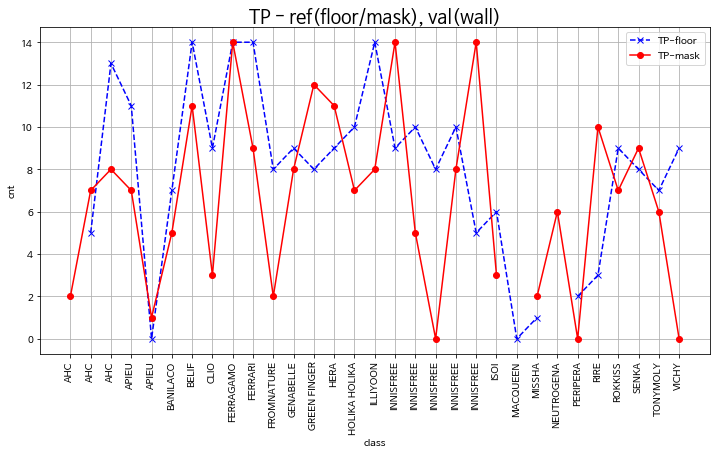

In [122]:
font_title = {'family': 'NanumBarunGothic', 'size': 18, 'color': 'black'}
plt.subplots(figsize=(12,6))
plt.plot(tps2, c='b', marker='x', ls='--', label='TP-floor')
plt.plot(tps, c='r', marker='o', label='TP-mask')
# plt.plot(fps2, c='b', marker='x', ls='--', label='FP-floor')
# plt.plot(fps, c='r', marker='o', label='FP-mask')
plt.xticks(range(len(voc_val_dataset.classes)), class_trun, rotation=90)
plt.xlabel('class')
plt.ylabel('cnt')
# plt.ylim([0,20])
plt.grid()
plt.title('TP - ref(floor/mask), val(wall)', fontdict=font_title)
plt.legend(loc='upper right')
plt.show()

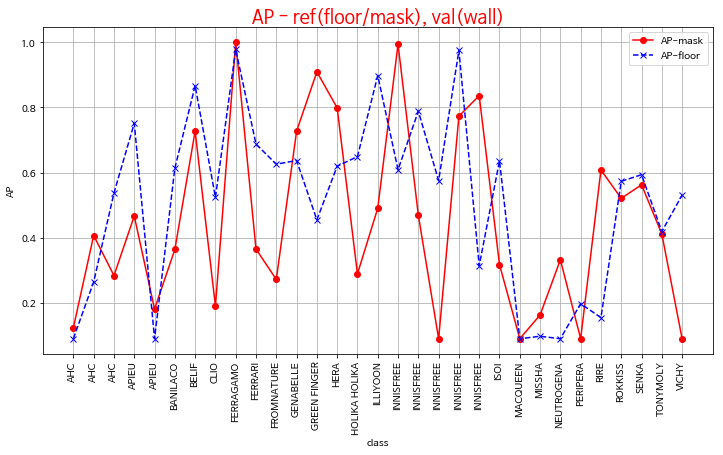

In [121]:
font_title = {'family': 'NanumBarunGothic', 'size': 18, 'color':  'red'}
plt.subplots(figsize=(12,6))
plt.plot(AP_list, c='r', marker='o', label='AP-mask')
plt.plot(AP_list_front, c='b', marker='x', ls='--', label='AP-floor')
plt.xticks(range(len(voc_val_dataset.classes)), class_trun, rotation=90)
plt.xlabel('class')
plt.ylabel('AP')
plt.grid()
plt.title('AP - ref(floor/mask), val(wall)', fontdict=font_title)
plt.legend(loc='upper right')
plt.show()

___
# help

In [2]:
import torch
import numpy as np
from torch.utils.data import Dataset, ConcatDataset, Sampler, RandomSampler, BatchSampler

In [182]:
# https://hulk89.github.io/pytorch/2019/09/30/pytorch_dataset/
class MapDataset(Dataset):
    def __len__(self):
        return 10
    
    def __getitem__(self, idx):
        return {"input":torch.tensor([idx, 2*idx, 3*idx], 
                                     dtype=torch.float32), 
                "label": torch.tensor(idx, 
                                      dtype=torch.float32)}

map_dataset = MapDataset()

In [183]:
map_dataset[1]

{'input': tensor([1., 2., 3.]), 'label': tensor(1.)}

In [184]:
dataloader = torch.utils.data.DataLoader(map_dataset)
for data in dataloader:
    print(data['label'], data['input'])

tensor([0.]) tensor([[0., 0., 0.]])
tensor([1.]) tensor([[1., 2., 3.]])
tensor([2.]) tensor([[2., 4., 6.]])
tensor([3.]) tensor([[3., 6., 9.]])
tensor([4.]) tensor([[ 4.,  8., 12.]])
tensor([5.]) tensor([[ 5., 10., 15.]])
tensor([6.]) tensor([[ 6., 12., 18.]])
tensor([7.]) tensor([[ 7., 14., 21.]])
tensor([8.]) tensor([[ 8., 16., 24.]])
tensor([9.]) tensor([[ 9., 18., 27.]])


In [12]:
dataloader = torch.utils.data.DataLoader(map_dataset, shuffle=True,
                                         batch_size=4)
for data in dataloader:
    print(data['input'], data['label'])

tensor([[ 7., 14., 21.],
        [ 1.,  2.,  3.],
        [ 2.,  4.,  6.],
        [ 0.,  0.,  0.]]) tensor([7., 1., 2., 0.])
tensor([[ 8., 16., 24.],
        [ 6., 12., 18.],
        [ 5., 10., 15.],
        [ 4.,  8., 12.]]) tensor([8., 6., 5., 4.])
tensor([[ 3.,  6.,  9.],
        [ 9., 18., 27.]]) tensor([3., 9.])


In [17]:
point_sampler = RandomSampler(map_dataset)
dataloader = torch.utils.data.DataLoader(map_dataset,
                                         batch_size=4,
                                         sampler=point_sampler)
for data in dataloader:
    print(data['input'], data['label'])

tensor([[ 4.,  8., 12.],
        [ 1.,  2.,  3.],
        [ 7., 14., 21.],
        [ 0.,  0.,  0.]]) tensor([4., 1., 7., 0.])
tensor([[ 9., 18., 27.],
        [ 2.,  4.,  6.],
        [ 3.,  6.,  9.],
        [ 5., 10., 15.]]) tensor([9., 2., 3., 5.])
tensor([[ 8., 16., 24.],
        [ 6., 12., 18.]]) tensor([8., 6.])


In [23]:
point_sampler = RandomSampler(map_dataset)
batch_sampler = BatchSampler(point_sampler, 2, False)
dataloader = torch.utils.data.DataLoader(map_dataset,
                                         batch_sampler=batch_sampler)
for data in dataloader:
    print(data['input'], data['label'])

tensor([[ 9., 18., 27.],
        [ 0.,  0.,  0.]]) tensor([9., 0.])
tensor([[ 5., 10., 15.],
        [ 1.,  2.,  3.]]) tensor([5., 1.])
tensor([[3., 6., 9.],
        [2., 4., 6.]]) tensor([3., 2.])
tensor([[ 6., 12., 18.],
        [ 8., 16., 24.]]) tensor([6., 8.])
tensor([[ 4.,  8., 12.],
        [ 7., 14., 21.]]) tensor([4., 7.])


In [25]:
class VarMapDataset(Dataset):
    def __len__(self):
        return 10
    
    def __getitem__(self, idx):
        return {"input":torch.tensor([idx] * (idx+1), 
                                     dtype=torch.float32), 
                "label": torch.tensor(idx, 
                                      dtype=torch.float32)}

var_map_dataset = VarMapDataset()

In [32]:
dataloader = torch.utils.data.DataLoader(var_map_dataset)
for data in dataloader:
    print(data['input'])

tensor([[0.]])
tensor([[1., 1.]])
tensor([[2., 2., 2.]])
tensor([[3., 3., 3., 3.]])
tensor([[4., 4., 4., 4., 4.]])
tensor([[5., 5., 5., 5., 5., 5.]])
tensor([[6., 6., 6., 6., 6., 6., 6.]])
tensor([[7., 7., 7., 7., 7., 7., 7., 7.]])
tensor([[8., 8., 8., 8., 8., 8., 8., 8., 8.]])
tensor([[9., 9., 9., 9., 9., 9., 9., 9., 9., 9.]])


In [39]:
def make_batch(samples):
    inputs = [sample['input'] for sample in samples]
    labels = [sample['label'] for sample in samples]
    padded_inputs = torch.nn.utils.rnn.pad_sequence(inputs, batch_first=True)
    return {'input': padded_inputs.contiguous(),
            'label': torch.stack(labels).contiguous()}
    
dataloader = torch.utils.data.DataLoader(var_map_dataset,
                                         batch_size=3, shuffle=True,
                                         collate_fn=make_batch)
for data in dataloader:
    print(data['input'], data['label'])

tensor([[6., 6., 6., 6., 6., 6., 6., 0., 0., 0.],
        [9., 9., 9., 9., 9., 9., 9., 9., 9., 9.],
        [4., 4., 4., 4., 4., 0., 0., 0., 0., 0.]]) tensor([6., 9., 4.])
tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [7., 7., 7., 7., 7., 7., 7., 7.],
        [3., 3., 3., 3., 0., 0., 0., 0.]]) tensor([0., 7., 3.])
tensor([[1., 1., 0., 0., 0., 0., 0., 0., 0.],
        [5., 5., 5., 5., 5., 5., 0., 0., 0.],
        [8., 8., 8., 8., 8., 8., 8., 8., 8.]]) tensor([1., 5., 8.])
tensor([[2., 2., 2.]]) tensor([2.])


___
# my dataset

In [6]:

def makeAnchors(boxes):
    """
    1:1, 1:2, 2:1 *scale(1, 0.75, 0.56) 총 9가지 앵커 생성
    @params boxes - N*4 , x,y,w,h
    """
    new_boxes = []
    for box in boxes:
        x,y,w,h = box
        cx = x+w/2
        cy = y+h/2
        for s in [1, 0.75, 0.75]: # 누적곱으로 비율 게산 즉, 1, 0.75, 0.75^2
            w = w*s
            h = h*s
            x = cx-w/2
            y = cy-h/2
            # w:h = 1:2, x2,y,w2,h
            w2 = w/2
            x2 = cx-w2/2
            # w:h = 2:1, x,y2,w,h2
            h2 = h/2
            y2 = cy-h2/2
            new_box = np.array([[x,y,w,h],[x2,y,w2,h],[x,y2,w,h2]])
            new_boxes.append(new_box)
    new_boxes = np.concatenate(new_boxes).astype(np.int)
    return new_boxes

def rpn2(im, n_slice_x, n_slice_y, scale=(1,1)):
    """
    n분할 rpn
    @params im: nomalized image tensor N x C x W x H
    @return 
    """
    len_y, len_x, _ = im.shape
    w = len_x/n_slice_x
    h = len_y/n_slice_y

    cxs = [w/2+w*i for i in range(n_slice_x)]
    cys = [h/2+h*i for i in range(n_slice_y)]
    
    rois = []
    boxes = []
    for cx in cxs:
        for cy in cys:
            x=cx-w/2; y=cy-h/2
            w_diff = w*(1-scale[0])/2
            h_diff = h*(1-scale[1])/2
            w_modi = w*scale[0]
            h_modi = h*scale[1]
            x_modi = x+w_diff
            y_modi = y+h_diff

            boxes.append([max(0,x_modi),max(0,y_modi),w_modi,h_modi]) # x,y,w,h

    boxes = np.array(boxes)
    new_boxes = makeAnchors(boxes)
    return new_boxes

im = cv2.imread(".\\ttt.jpg")
%time boxes = rpn2(im, n_slice_x=1, n_slice_y=1, scale=[0.5, 0.8])
for idx, b in enumerate(boxes):
    x, y, w, h = b
    cv2.rectangle(im, (x, y), (x+w, y+h), (0, 255, 255), 1, cv2.LINE_AA)

cv2.imshow("edgeboxes", im)
cv2.waitKey(0)
cv2.destroyAllWindows()        

Wall time: 0 ns


In [10]:
import os
import shutil
from tqdm import tqdm_notebook as tqdm
from time import sleep

"""
bbox 샘플들 내려받기
/temp
"""
dir = 'new-cosmetic-frontview2'
root_dir = 'C:\\Users\\LSW\\Desktop\\Smart_mirror\\Yolo_mark\\x64\\Release\\cosmetic-data\\%s\\temp'%dir
class_path = 'C:\\Users\\LSW\\Desktop\\Smart_mirror\\Yolo_mark\\x64\\Release\\cosmetic-data\\obj.names'

dd_dataset = MyDataset(root_dir, class_path, 
                      transform=transforms.Compose([
        transforms.ToTensor(),
    ])
)

dir_bbox = os.path.join(dir, 'bbox')
if os.path.isdir(dir_bbox):
    shutil.rmtree(dir_bbox)

sleep(0.5)
os.mkdir(dir_bbox)

for i in tqdm(range(len(dd_dataset))):
    im_tensor, targets_gt, boxes_gt = dd_dataset[i]
#     print(im_tensor.shape)
    roi = im_tensor[:,:,boxes_gt[0][1]:boxes_gt[0][1]+boxes_gt[0][3], boxes_gt[0][0]:boxes_gt[0][0]+boxes_gt[0][2]]
    torchvision.utils.save_image(roi, dir_bbox+'/'+dd_dataset.classes[targets_gt[0]]+'_'+str(i)+'.jpg')

A Jupyter Widget